# Role Vector Analysis

This notebook computes role vectors for various metrics using activation summaries and response ratings.

In [1]:
import json
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print(f"CWD: {os.getcwd()}")

CWD: /home/nate/repos/animacy/results/activations/analysis


In [2]:
# Paths
ACTIVATIONS_DIR = Path("../data/gemma-3-27b-it")
RATINGS_PATH = Path("../../ratings/data/gemma-3-27b-it/response_ratings.csv")
WORD_PROPS_PATH = Path("../../../data/selected_words.csv")
OUTPUT_DIR = Path("../../steering/data/gemma-3-27b-it")
PLOTS_DIR = OUTPUT_DIR / "plots"

# Ensure output directory exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Activations Dir: {ACTIVATIONS_DIR.resolve()}")
print(f"Ratings Path: {RATINGS_PATH.resolve()}")
print(f"Word Props Path: {WORD_PROPS_PATH.resolve()}")
print(f"Output Dir: {OUTPUT_DIR.resolve()}")
print(f"Plots Dir: {PLOTS_DIR.resolve()}")

Activations Dir: /home/nate/repos/animacy/results/activations/data/gemma-3-27b-it
Ratings Path: /home/nate/repos/animacy/results/ratings/data/gemma-3-27b-it/response_ratings.csv
Word Props Path: /home/nate/repos/animacy/data/selected_words.csv
Output Dir: /home/nate/repos/animacy/results/steering/data/gemma-3-27b-it
Plots Dir: /home/nate/repos/animacy/results/steering/data/gemma-3-27b-it/plots


In [3]:
# Load word properties for group mapping
word_props = pd.read_csv(WORD_PROPS_PATH)
role_to_group = dict(zip(word_props['word'], word_props['group']))

# Add assistant roles to the mapping manually
assistant_roles = ["AI", "assistant", "AI assistant", "helpful assistant", "llm"]
for role in assistant_roles:
    role_to_group[role] = "Assistant"

print(f"Loaded {len(word_props)} word properties.")

Loaded 125 word properties.


In [4]:
# Load Ratings
if not RATINGS_PATH.exists():
    print(f"ERROR: Ratings file not found at {RATINGS_PATH.resolve()}")
else:
    ratings = pd.read_csv(RATINGS_PATH)
    print(f"Loaded {len(ratings)} ratings.")

    # Identify deviation columns
    deviation_cols = ["assistant_refusal", "role_refusal", "identify_as_assistant", "deny_internal_experience"]
    # Ensure boolean
    for col in deviation_cols:
        if col in ratings.columns:
            ratings[col] = ratings[col].fillna(False).astype(bool)

    ratings["has_deviation"] = ratings[deviation_cols].any(axis=1)
    print(f"Trials with deviations: {ratings['has_deviation'].sum()}")

Loaded 6350 ratings.
Trials with deviations: 368


In [5]:
def load_activations(base_dir, sys_type="with_sys"):
    data = []
    summaries_dir = base_dir / sys_type / "summaries"
    
    print(f"Checking summaries dir: {summaries_dir.resolve()}")
    if not summaries_dir.exists():
        print(f"Warning: {summaries_dir} does not exist.")
        return pd.DataFrame()
        
    files = list(summaries_dir.glob("*.json"))
    print(f"Loading {len(files)} files from {sys_type}...")
    
    for file_path in tqdm(files):
        filename = file_path.name
        try:
            stem = file_path.stem
            parts = stem.split("_")
            
            layer_part = parts[-1]
            layer = int(layer_part.replace("layer", ""))
            sample_idx = int(parts[-2])
            
            entry = {
                "sys_type": sys_type,
                "filename_stem": "_".join(parts),
                "sample_idx": sample_idx,
                "layer": layer,
            }
            
            with open(file_path, "r") as f:
                content = json.load(f)
            
            for key, value in content.items():
                if isinstance(value, list):
                    entry[key] = np.array(value)
            
            data.append(entry)
        except Exception as e:
            print(f"Error parsing {filename}: {e}")
            continue
            
    df = pd.DataFrame(data)
    return df

In [6]:
# Get unique roles and tasks from ratings to help parsing
known_roles = set(ratings["role_name"].dropna().unique())
known_tasks = set(ratings["task_name"].dropna().unique())

print(f"Known roles: {len(known_roles)}")
print(f"Known tasks: {len(known_tasks)}")

def parse_role_task(filename_stem, known_roles, known_tasks):
    # Ensure r is string
    role_map = {str(r).replace(" ", "_"): str(r) for r in known_roles}
    best_role = None
    best_task = None
    
    for r_underscore in role_map:
        if filename_stem.startswith(r_underscore):
            remainder = filename_stem[len(r_underscore):]
            if remainder.startswith("_"):
                task_part = remainder[1:]
                if task_part in known_tasks:
                    if best_role is None or len(r_underscore) > len(best_role.replace(" ", "_")):
                        best_role = role_map[r_underscore]
                        best_task = task_part
    
    if best_role:
        return best_role, best_task
    
    parts = filename_stem.split("_", 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return filename_stem, ""

Known roles: 125
Known tasks: 10


In [7]:
# Load with_sys activations
df_with_sys = load_activations(ACTIVATIONS_DIR, "with_sys")

if df_with_sys.empty:
    print("ERROR: df_with_sys is empty!")
else:
    # Parse roles and tasks
    parsed = df_with_sys["filename_stem"].apply(lambda x: parse_role_task(x, known_roles, known_tasks))
    df_with_sys["role"] = parsed.apply(lambda x: x[0])
    df_with_sys["task"] = parsed.apply(lambda x: x[1])

    print(f"Loaded {len(df_with_sys)} with_sys activations.")
    print(df_with_sys.head())

Checking summaries dir: /home/nate/repos/animacy/results/activations/data/gemma-3-27b-it/with_sys/summaries
Loading 25000 files from with_sys...


  0%|          | 0/25000 [00:00<?, ?it/s]

Error parsing weed_meaning_of_life_1_layer56.json: Expecting value: line 1 column 1 (char 0)
Loaded 24999 with_sys activations.
   sys_type                 filename_stem  sample_idx  layer  \
0  with_sys           roof_poem_1_layer56           1     56   
1  with_sys          cop_dreams_4_layer44           4     44   
2  with_sys        surgeon_poem_2_layer56           2     56   
3  with_sys  engineer_past_self_1_layer48           1     48   
4  with_sys       corridor_poem_4_layer56           4     56   

                                   avg_system_prompt  \
0  [218.0, 196.0, -187.0, -41.5, 87.5, 256.0, 4.3...   
1  [44.75, 235.0, -95.0, -16.625, -93.5, 57.25, 2...   
2  [169.0, 362.0, -114.5, -83.0, 103.5, -11.3125,...   
3  [38.75, 266.0, -44.5, -65.0, -106.5, 125.0, 6....   
4  [330.0, 386.0, -119.5, -50.5, 240.0, 236.0, -7...   

                                     avg_user_prompt  \
0  [-93.0, 150.0, -468.0, -40.0, -406.0, 258.0, 6...   
1  [-49.0, 175.0, -87.5, 48.75, -153.0

In [8]:
def visualize_role_vectors(role_vectors, metric_name, layers_to_plot=None, method='pca', save_plots=False):
    """
    Visualize role vectors using PCA or UMAP.
    
    Args:
        role_vectors: dict of {role: {layer: vector}}
        metric_name: name of the metric being visualized
        layers_to_plot: list of layers to visualize (default: [10, 20, 30, 40])
        method: 'pca' or 'umap'
        save_plots: whether to save plots to PLOTS_DIR
    """
    if layers_to_plot is None:
        layers_to_plot = [44, 48, 52, 56]
    
    # Get all unique layers from role vectors
    all_layers = set()
    for role_dict in role_vectors.values():
        all_layers.update(role_dict.keys())
    all_layers = sorted(all_layers)
    
    # Filter to only plot layers that exist
    layers_to_plot = [l for l in layers_to_plot if l in all_layers]
    
    # Create color mapping based on groups
    groups_unique = sorted(set([role_to_group.get(role, "Unknown") for role in role_vectors.keys()]))
    # Remove "Unknown" from groups
    groups_unique = [g for g in groups_unique if g != "Unknown"]
    palette = sns.color_palette("tab10", n_colors=len(groups_unique))
    group_color_map = dict(zip(groups_unique, palette))
    
    for layer in layers_to_plot:
        # Collect vectors for this layer
        roles = []
        groups = []
        vectors = []
        
        for role, role_dict in role_vectors.items():
            if layer in role_dict:
                group = role_to_group.get(role, "Unknown")
                # Skip unknown groups
                if group == "Unknown":
                    continue
                roles.append(role)
                groups.append(group)
                vectors.append(role_dict[layer])
        
        if len(vectors) < 3:
            print(f"Not enough data for layer {layer} (only {len(vectors)} roles)")
            continue
        
        # Stack vectors
        X = np.stack(vectors)
        
        # Apply dimensionality reduction
        if method == "pca":
            reducer = PCA(n_components=2)
            title_prefix = "PCA"
        elif method == "umap":
            reducer = umap.UMAP(n_components=2, random_state=42)
            title_prefix = "UMAP"
        else:
            print(f"Unknown method: {method}")
            continue
        
        X_embedded = reducer.fit_transform(X)
        
        # Create plot DataFrame
        plot_df = pd.DataFrame({
            "x": X_embedded[:, 0],
            "y": X_embedded[:, 1],
            "role": roles,
            "group": groups
        })
        
        # Plot
        plt.figure(figsize=(12, 10))
        
        # Scatter plot for individual roles
        sns.scatterplot(
            data=plot_df,
            x="x",
            y="y",
            hue="group",
            palette=group_color_map,
            s=100,
            alpha=0.6
        )
        
        # Calculate and plot group means
        group_means = plot_df.groupby("group")[["x", "y"]].mean().reset_index()
        
        # Plot group means as larger points
        for i, row in group_means.iterrows():
            plt.scatter(
                row["x"],
                row["y"],
                color=group_color_map[row["group"]],
                marker="o",
                s=400,
                edgecolors="black",
                linewidth=2
            )
        
        # Add text labels for roles (smaller, more transparent)
        for i, row in plot_df.iterrows():
            plt.text(row["x"]+0.02, row["y"], row["role"], fontsize=8, alpha=0.5)
        
        # Add text labels for group means
        for i, row in group_means.iterrows():
            plt.text(row["x"], row["y"] - 0.05, row["group"], fontsize=12, fontweight='bold', ha='center')
        
        plt.title(f"{title_prefix} of {metric_name} Role Vectors - Layer {layer}")
        plt.tight_layout()
        
        if save_plots:
            plot_path = PLOTS_DIR / f"{metric_name}_{method}_layer{layer}.png"
            plt.savefig(plot_path, dpi=150, bbox_inches='tight')
            print(f"Saved plot to {plot_path}")
        
        plt.show()

In [9]:
# Assistant roles definition
assistant_roles = ["AI", "assistant", "AI assistant", "helpful assistant"]

def get_assistant_baseline(df, metric_col, use_all_trials=True):
    if df.empty:
        return None
    mask = df["role"].isin(assistant_roles)
    assist_df = df[mask]
    
    if assist_df.empty:
        print(f"Warning: No assistant roles found for baseline in {metric_col}.")
        return None
    
    baseline = {}
    layers = assist_df["layer"].unique()
    
    for layer in layers:
        layer_data = assist_df[assist_df["layer"] == layer][metric_col]
        vectors = np.stack(layer_data.values)
        baseline[layer] = np.mean(vectors, axis=0)
        
    return baseline

def compute_and_save_metric(df, metric_col, metric_name, filter_deviations=False, assistant_baseline=None, output_dir=OUTPUT_DIR):
    if df.empty:
        print(f"Skipping {metric_name} because df is empty.")
        return

    if filter_deviations:
        df["sample_idx"] = df["sample_idx"].astype(int)
        ratings["sample_idx"] = ratings["sample_idx"].astype(int)
        
        merged = pd.merge(
            df,
            ratings[["role_name", "task_name", "sample_idx", "has_deviation"]],
            left_on=["role", "task", "sample_idx"],
            right_on=["role_name", "task_name", "sample_idx"],
            how="left"
        )
        merged["has_deviation"] = merged["has_deviation"].fillna(False)
        keep_mask = (~merged["has_deviation"]) | (merged["role"].isin(assistant_roles))
        working_df = merged[keep_mask].copy()
        print(f"Filtered {metric_name}: {len(df)} -> {len(working_df)} rows.")
    else:
        working_df = df.copy()
        
    role_vectors = {}
    roles = working_df["role"].unique()
    layers = working_df["layer"].unique()
    
    for role in tqdm(roles, desc=f"Computing {metric_name}"):
        role_vectors[role] = {}
        role_df = working_df[working_df["role"] == role]
        
        for layer in layers:
            layer_data = role_df[role_df["layer"] == layer][metric_col]
            if layer_data.empty:
                continue
                
            vectors = np.stack(layer_data.values)
            avg_vector = np.mean(vectors, axis=0)
            
            if assistant_baseline and layer in assistant_baseline:
                avg_vector = avg_vector - assistant_baseline[layer]
                
            role_vectors[role][layer] = avg_vector
            
    output_path = output_dir / f"role_vectors_{metric_name}.pkl"
    with open(output_path, "wb") as f:
        pickle.dump(role_vectors, f)
    print(f"Saved {metric_name} to {output_path}")
    
    return role_vectors

## 1. at_role_period (baseline subtracted)

In [10]:
if not df_with_sys.empty:
    # 1) at_role_period
    metric = "at_role_period"
    baseline = get_assistant_baseline(df_with_sys, metric)
    role_vectors_1 = compute_and_save_metric(df_with_sys, metric, metric, filter_deviations=False, assistant_baseline=baseline)

Computing at_role_period:   0%|          | 0/125 [00:00<?, ?it/s]

Saved at_role_period to ../../steering/data/gemma-3-27b-it/role_vectors_at_role_period.pkl


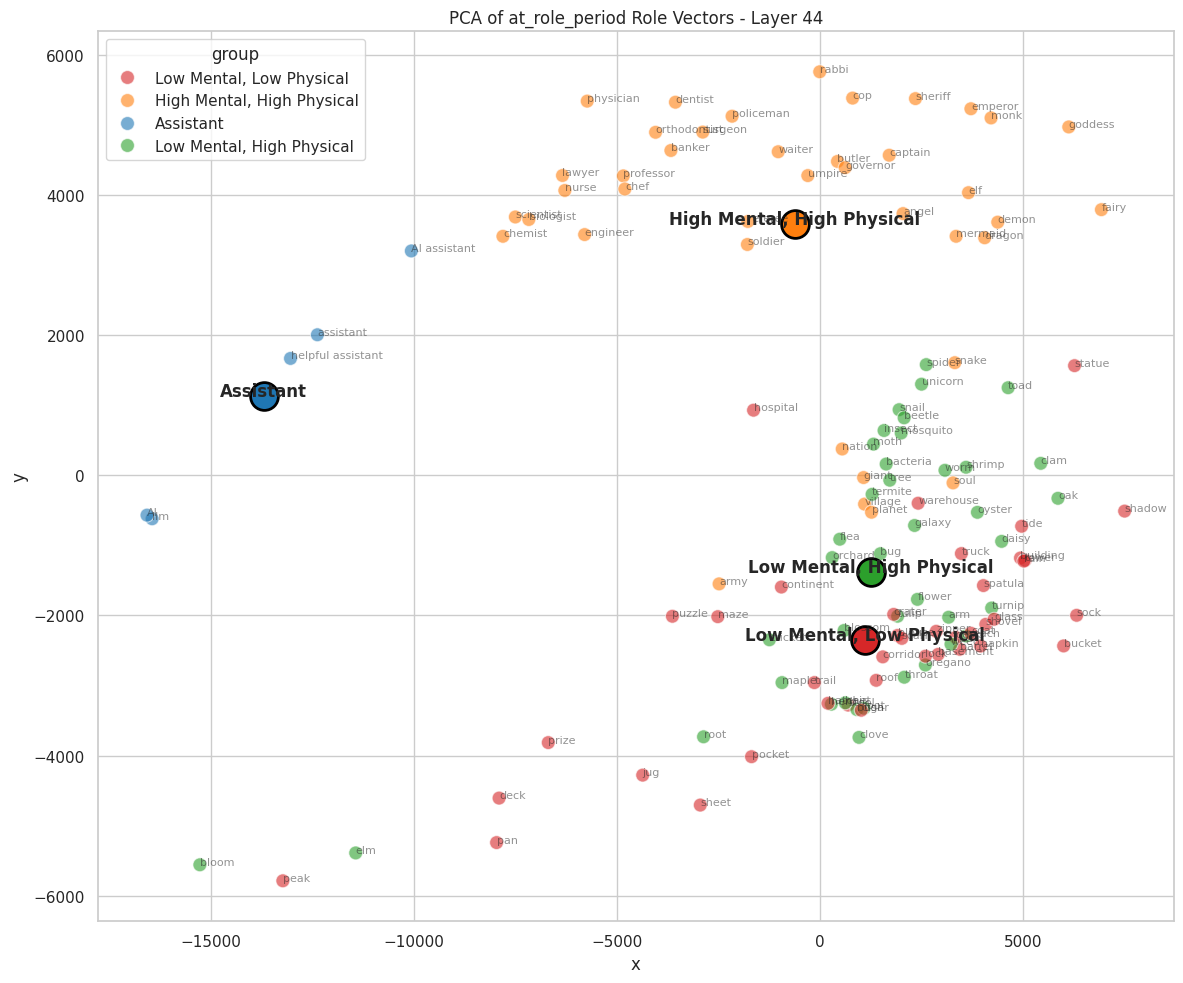

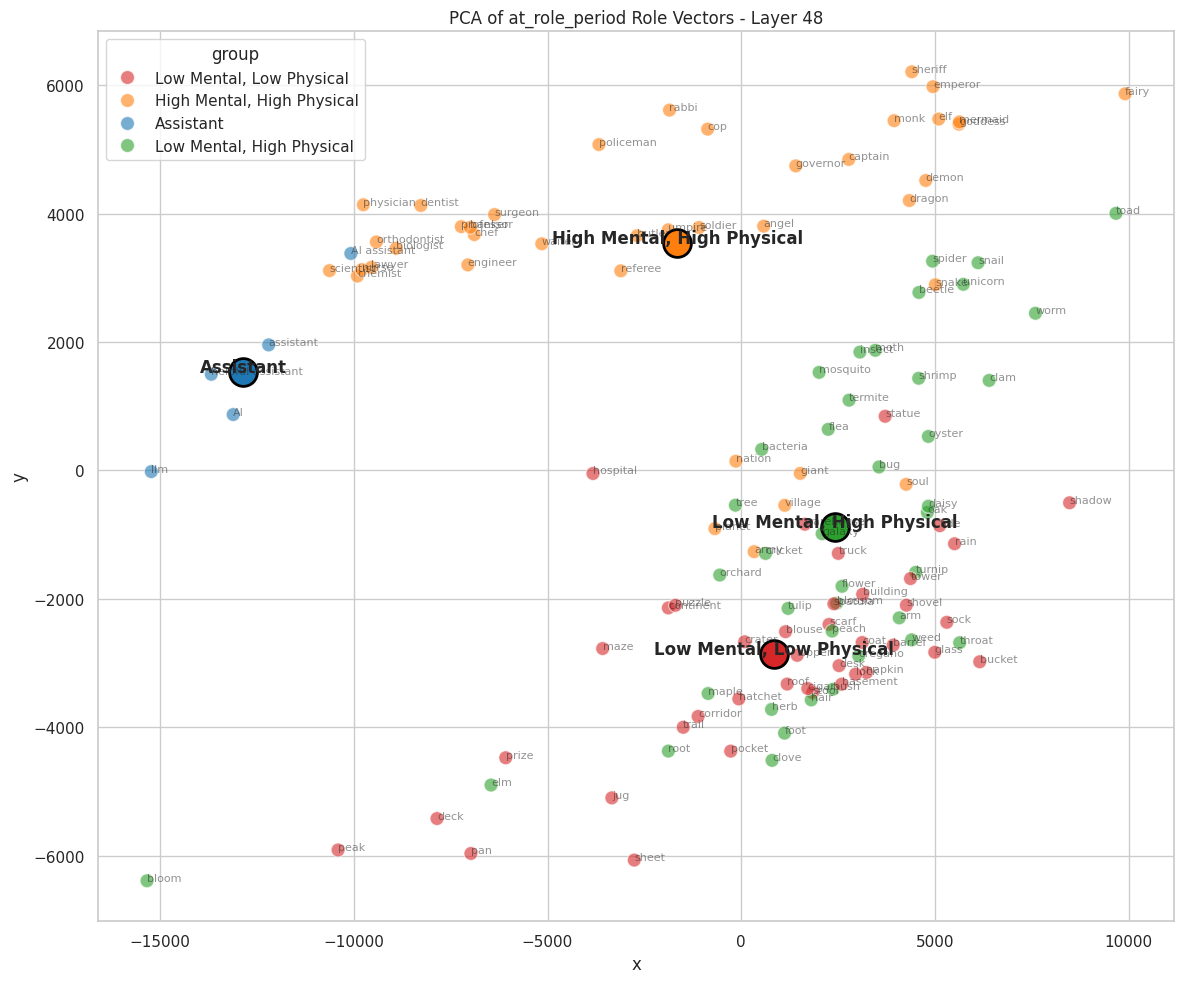

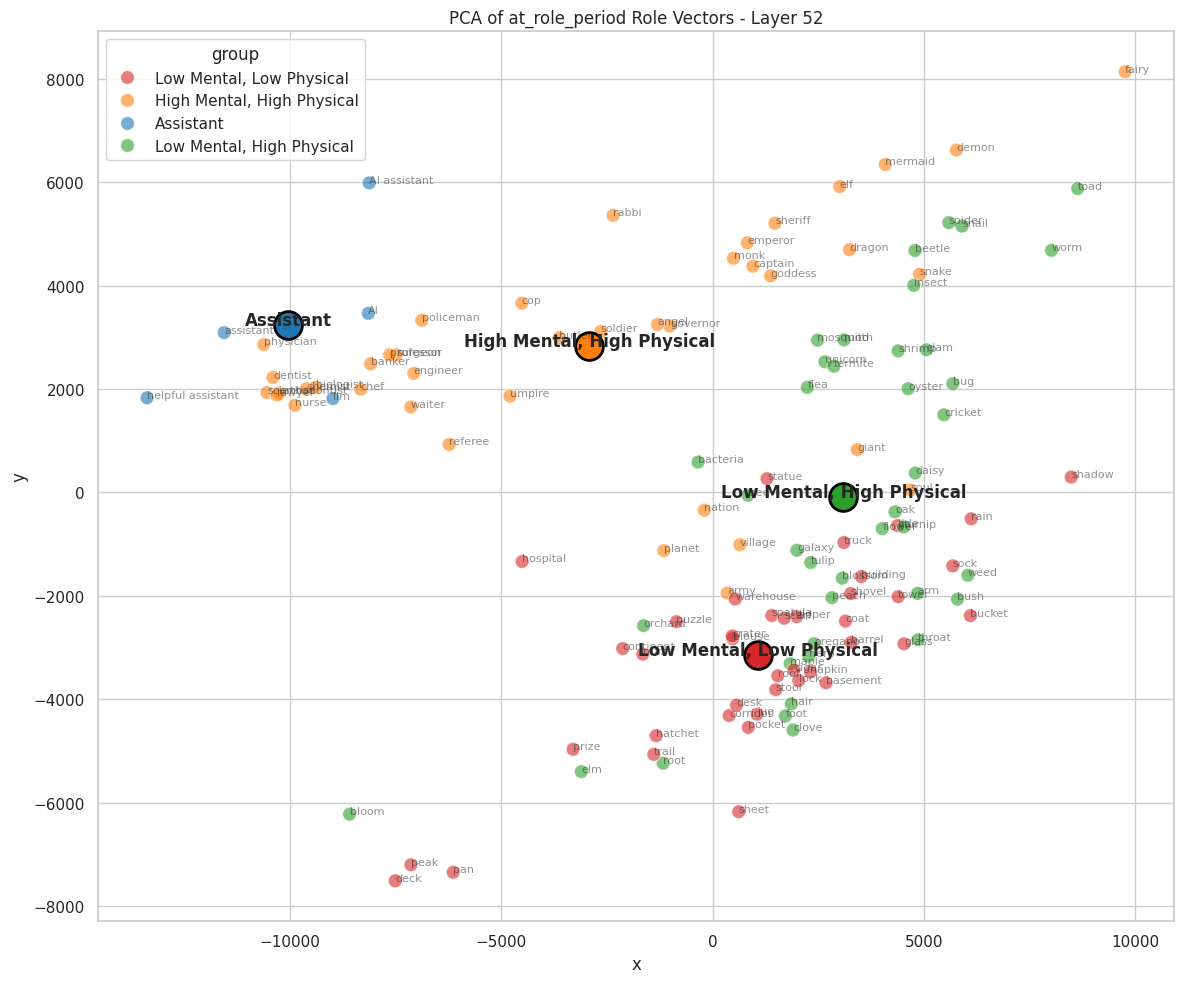

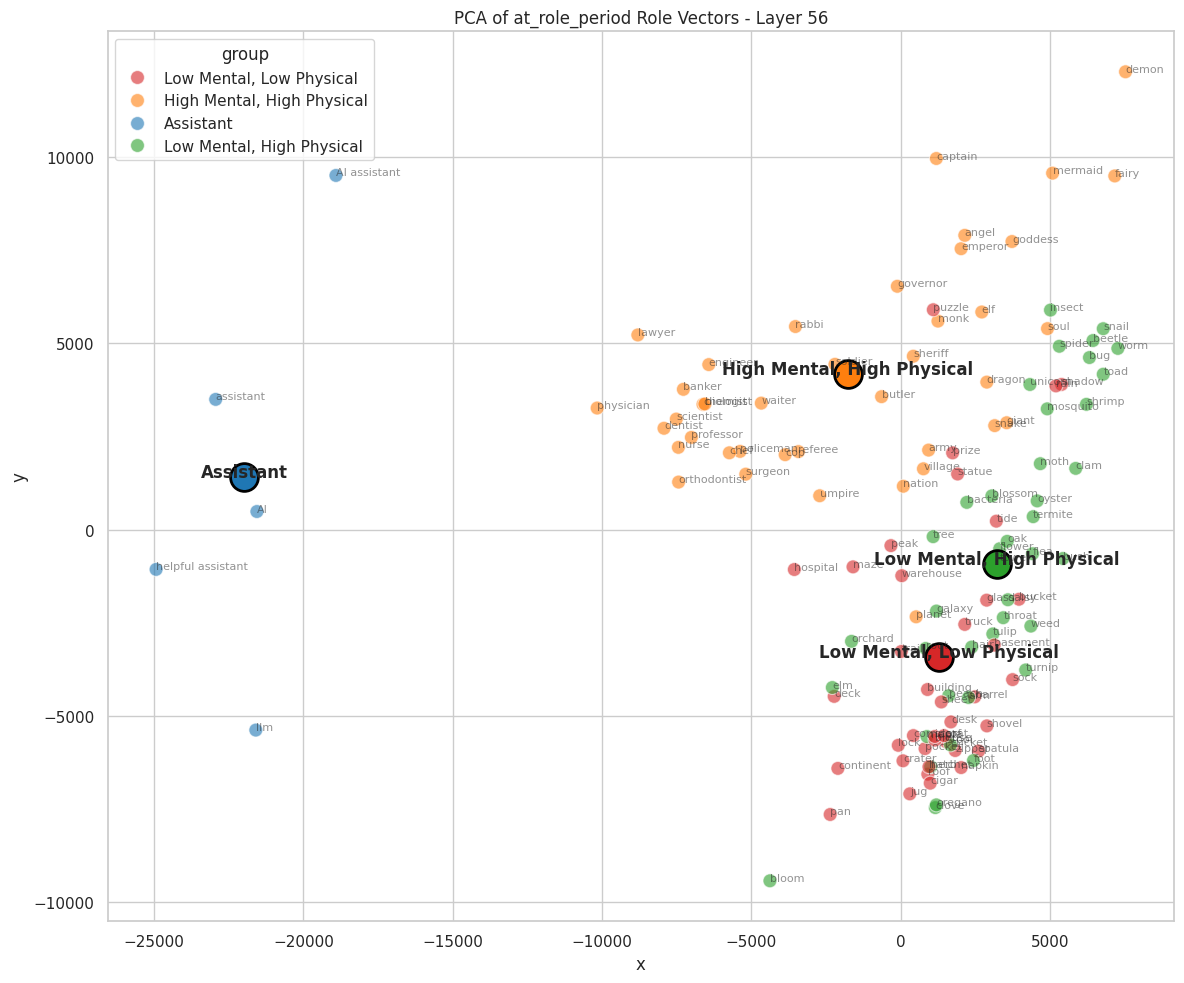

In [11]:
# Visualize at_role_period with PCA
if 'role_vectors_1' in locals():
    visualize_role_vectors(role_vectors_1, "at_role_period", method='pca')

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


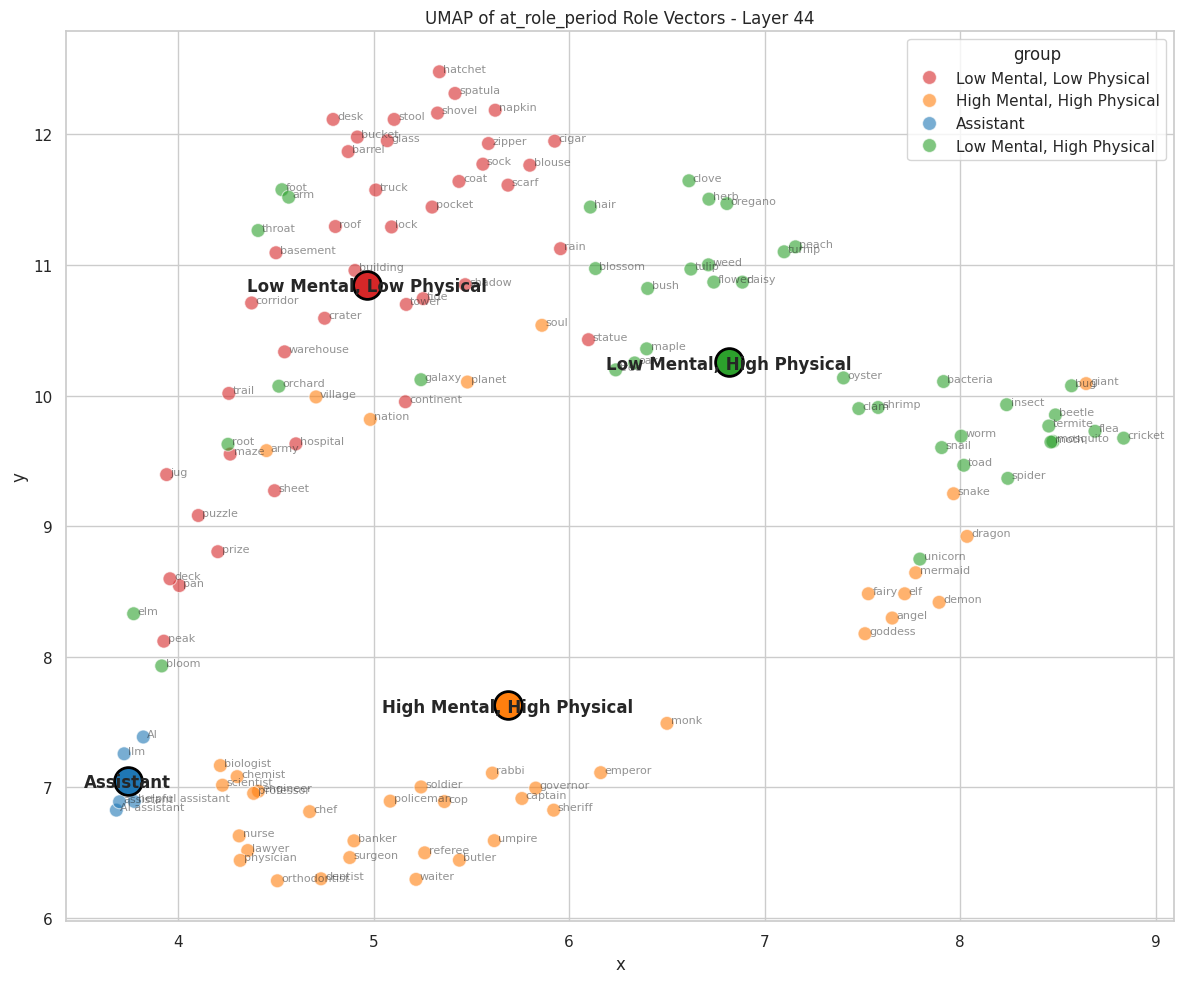

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


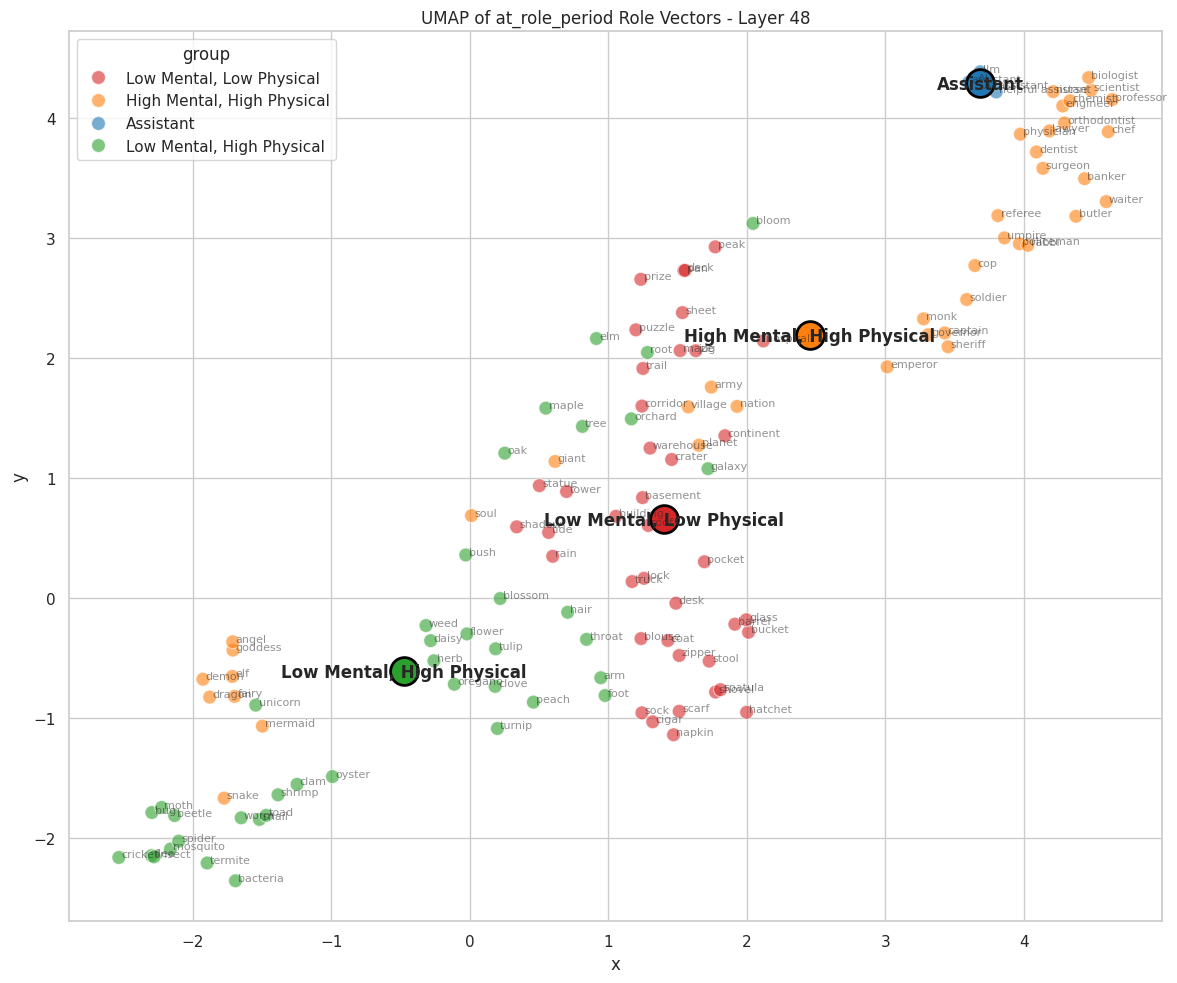

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


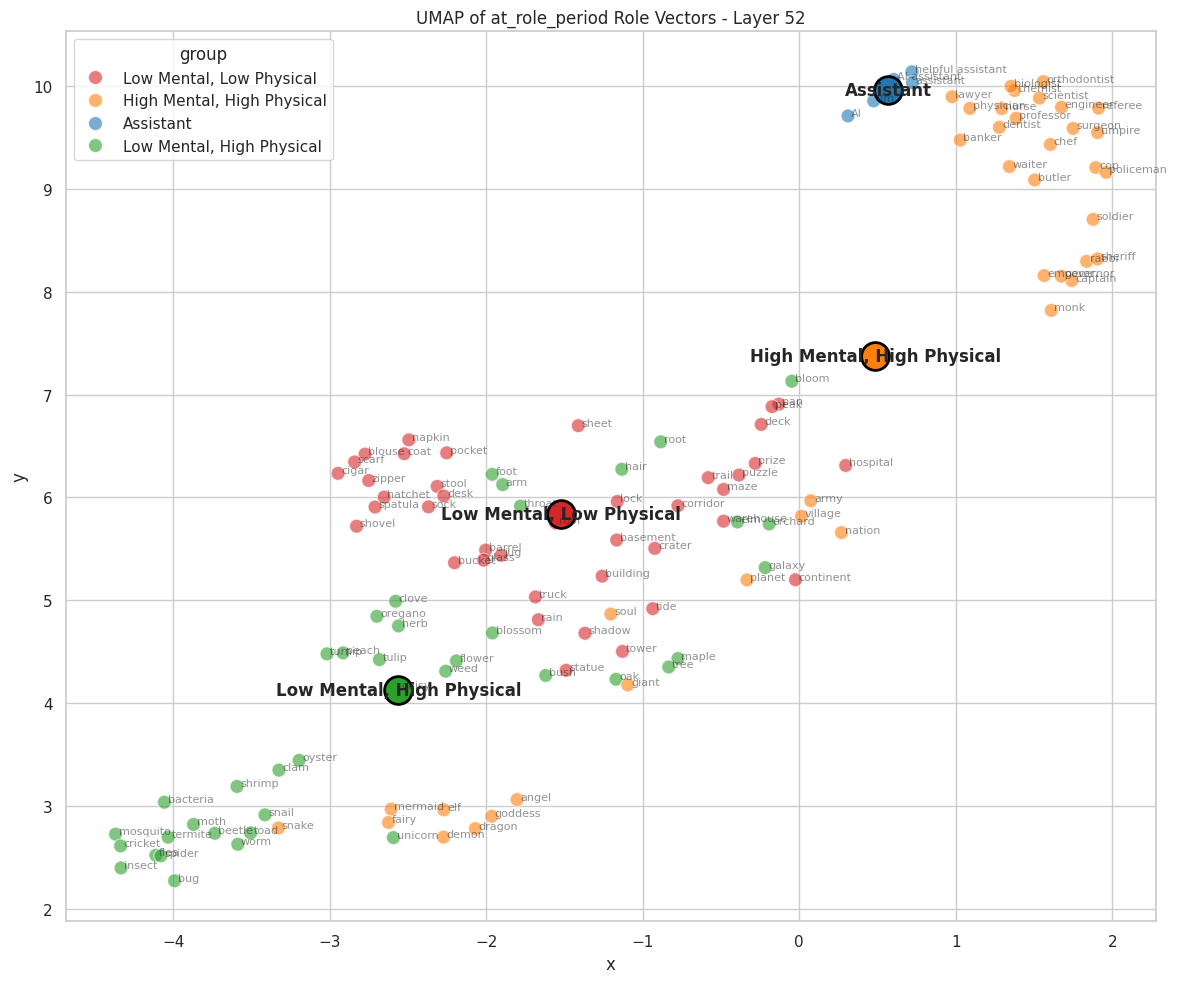

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


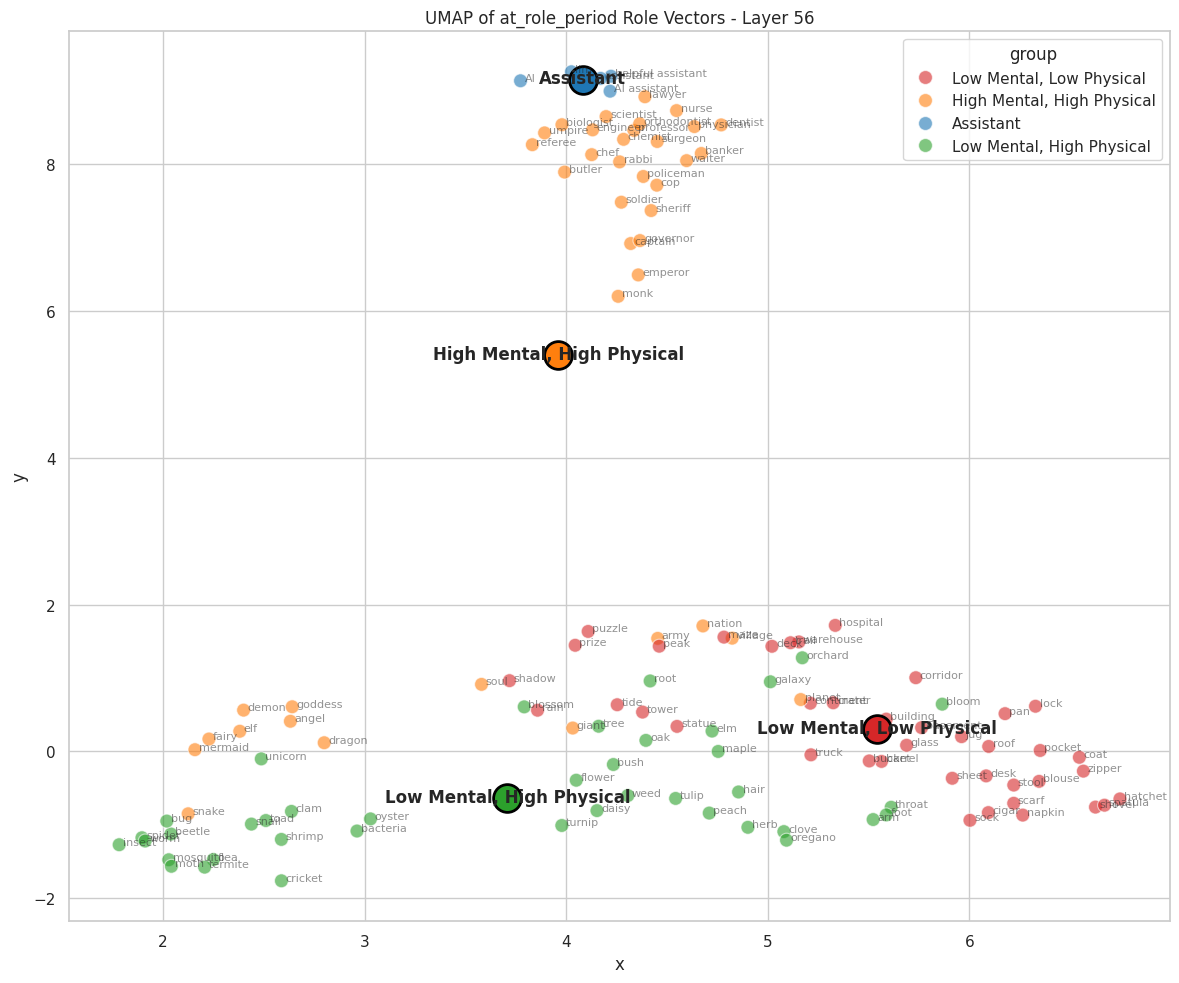

In [12]:
# Visualize at_role_period with UMAP
if 'role_vectors_1' in locals():
    visualize_role_vectors(role_vectors_1, "at_role_period", method='umap')

## 2. at_role (baseline subtracted)

In [13]:
if not df_with_sys.empty:
    # 2) at_role
    metric = "at_role"
    baseline = get_assistant_baseline(df_with_sys, metric)
    role_vectors_2 = compute_and_save_metric(df_with_sys, metric, metric, filter_deviations=False, assistant_baseline=baseline)

Computing at_role:   0%|          | 0/125 [00:00<?, ?it/s]

Saved at_role to ../../steering/data/gemma-3-27b-it/role_vectors_at_role.pkl


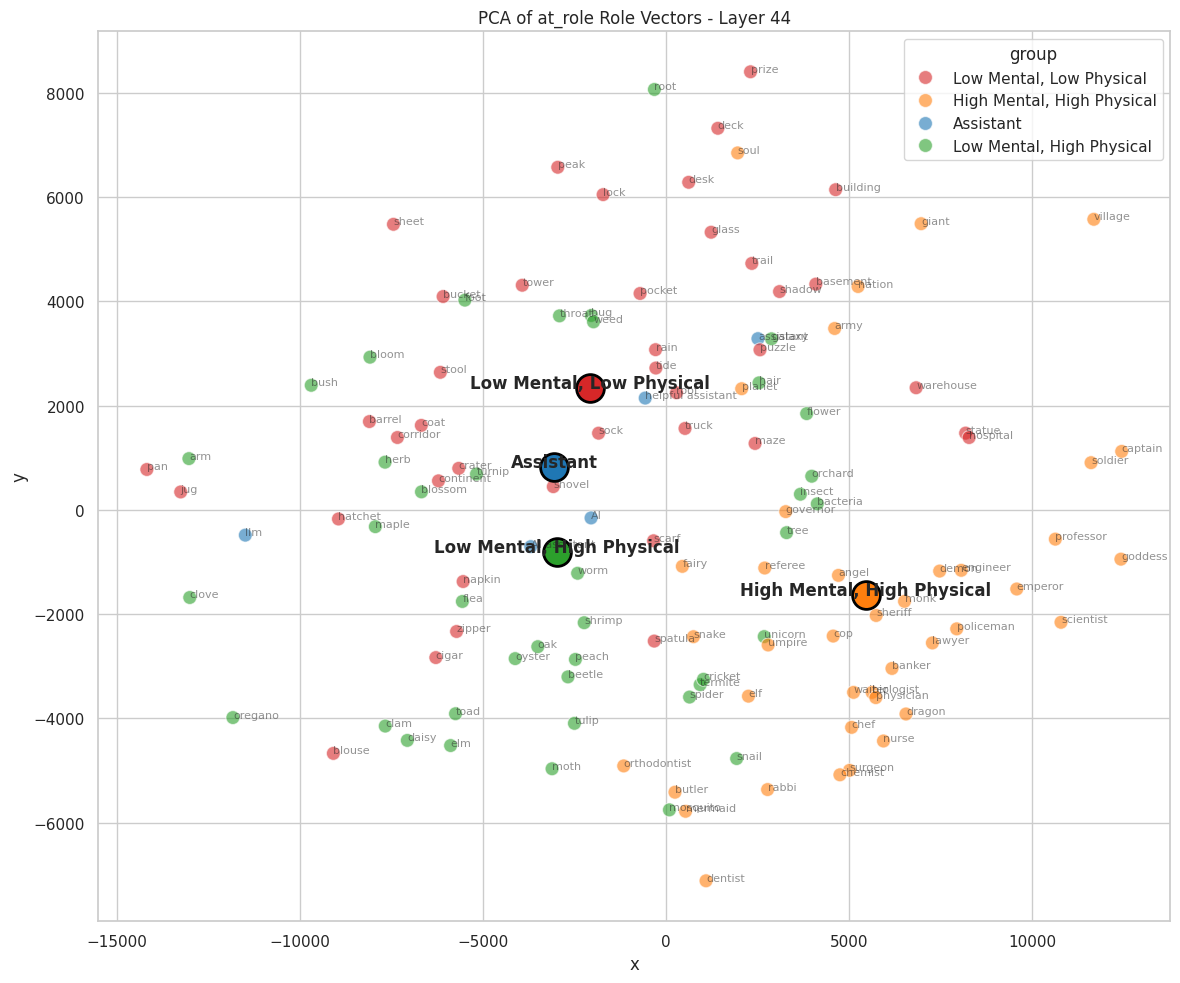

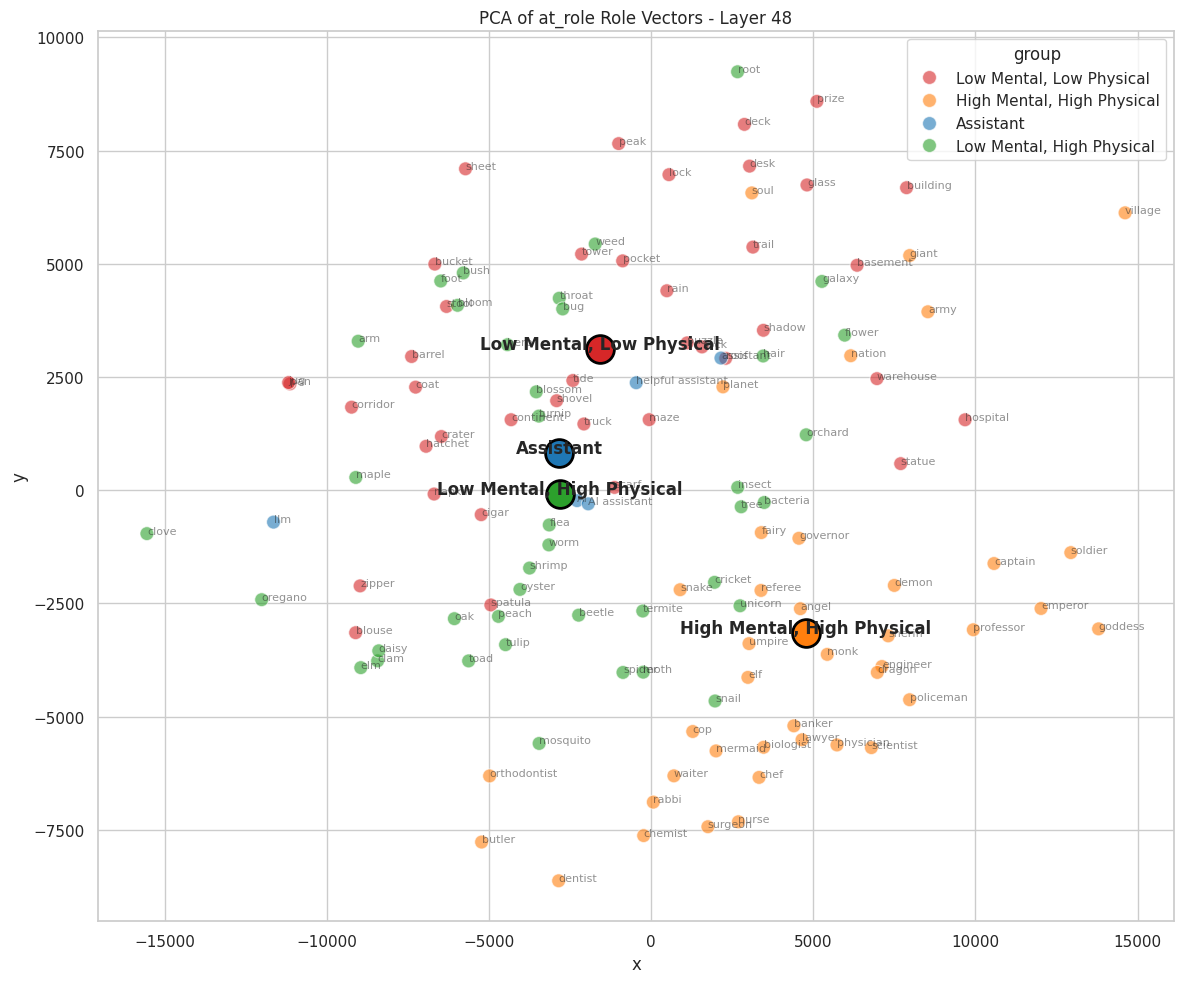

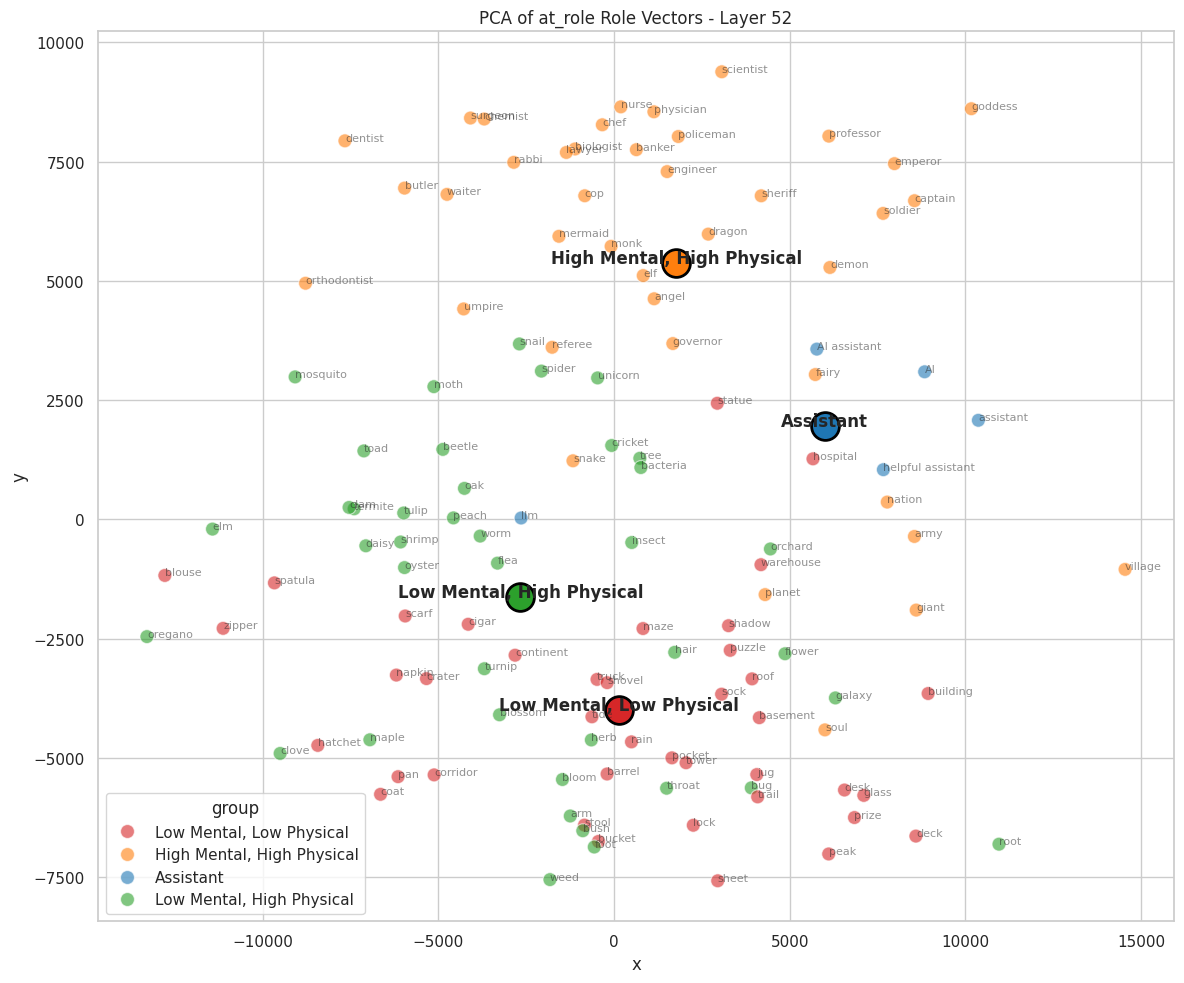

In [14]:
# Visualize at_role with PCA
if 'role_vectors_2' in locals():
    visualize_role_vectors(role_vectors_2, "at_role", method='pca')

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


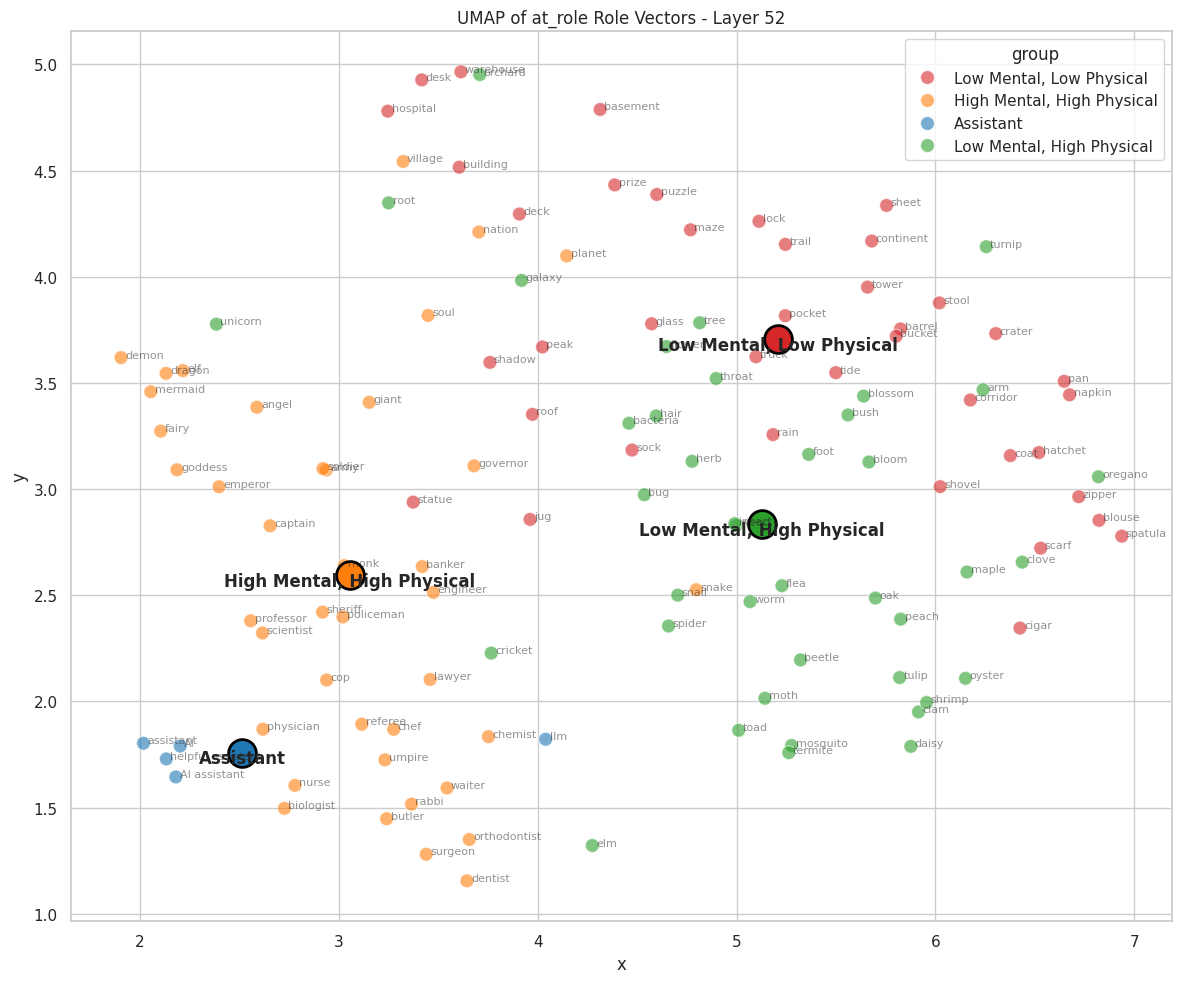

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


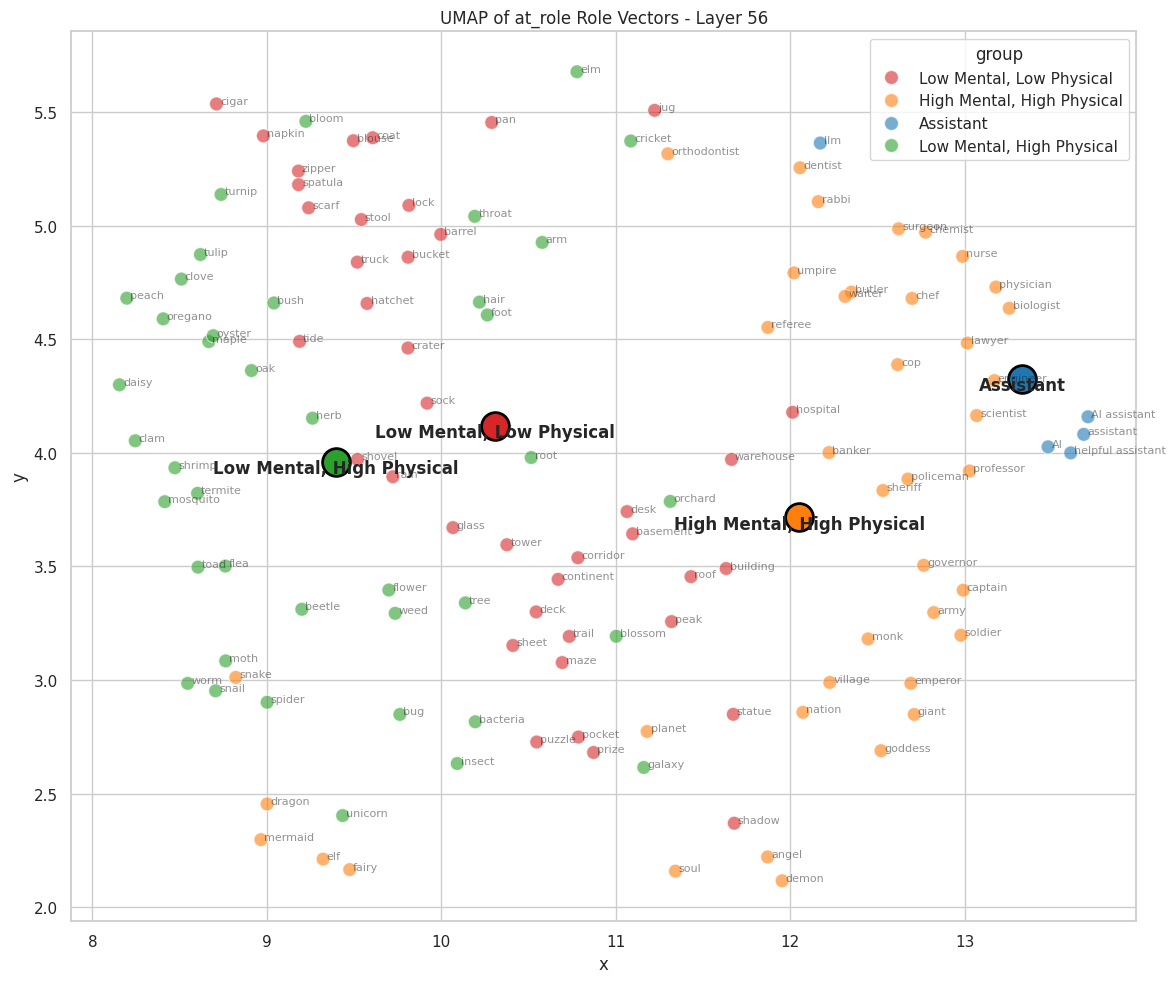

In [15]:
# Visualize at_role with UMAP
if 'role_vectors_2' in locals():
    visualize_role_vectors(role_vectors_2, "at_role", method='umap')

## 3. avg_response (filtered, baseline subtracted)

In [16]:
if not df_with_sys.empty:
    # 3) avg_response (Filtered)
    metric = "avg_response"
    baseline = get_assistant_baseline(df_with_sys, metric)
    role_vectors_3 = compute_and_save_metric(df_with_sys, metric, metric, filter_deviations=True, assistant_baseline=baseline)

Filtered avg_response: 24999 -> 24999 rows.


/tmp/ipykernel_173485/1232711009.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["has_deviation"] = merged["has_deviation"].fillna(False)


Computing avg_response:   0%|          | 0/125 [00:00<?, ?it/s]

Saved avg_response to ../../steering/data/gemma-3-27b-it/role_vectors_avg_response.pkl


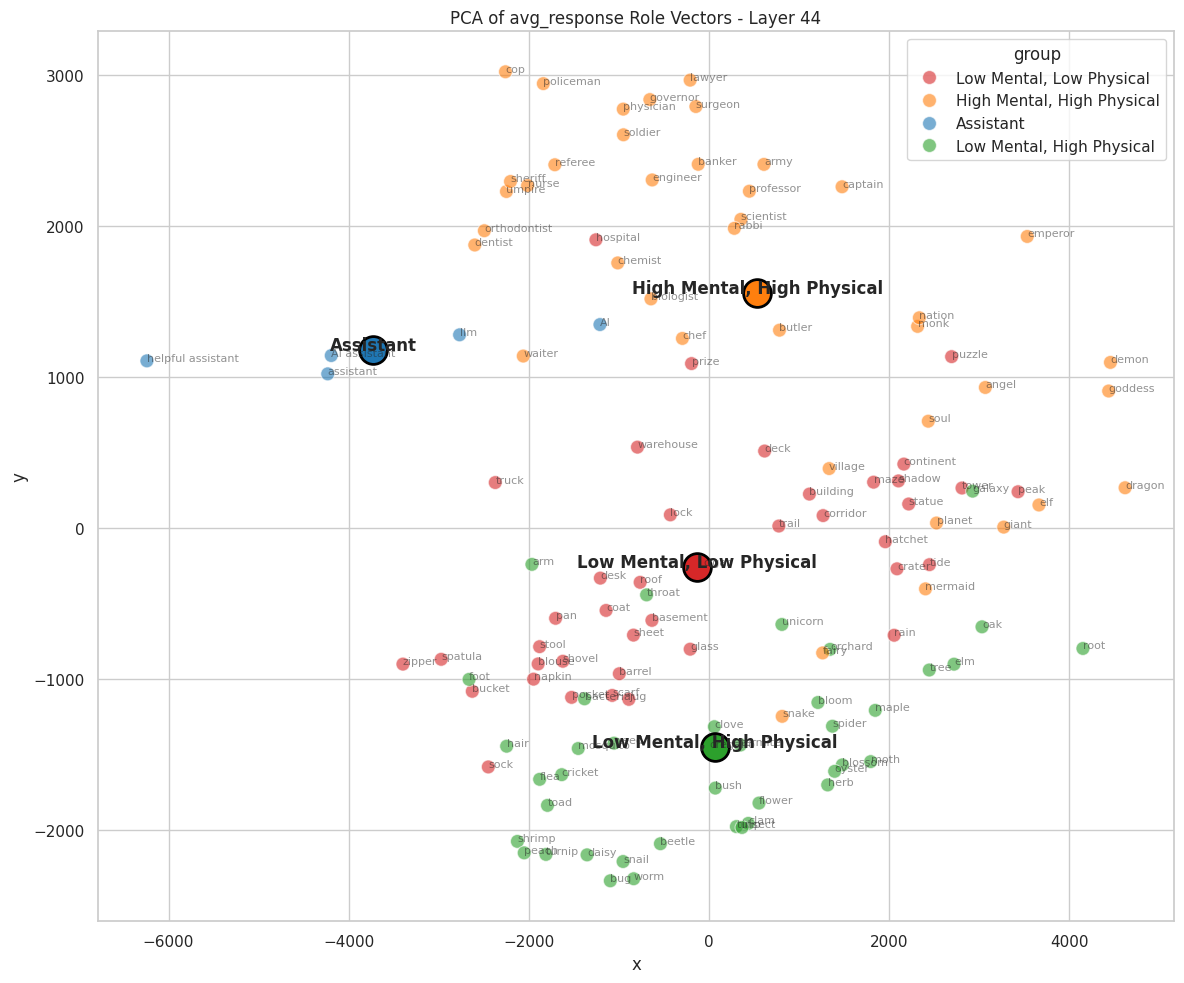

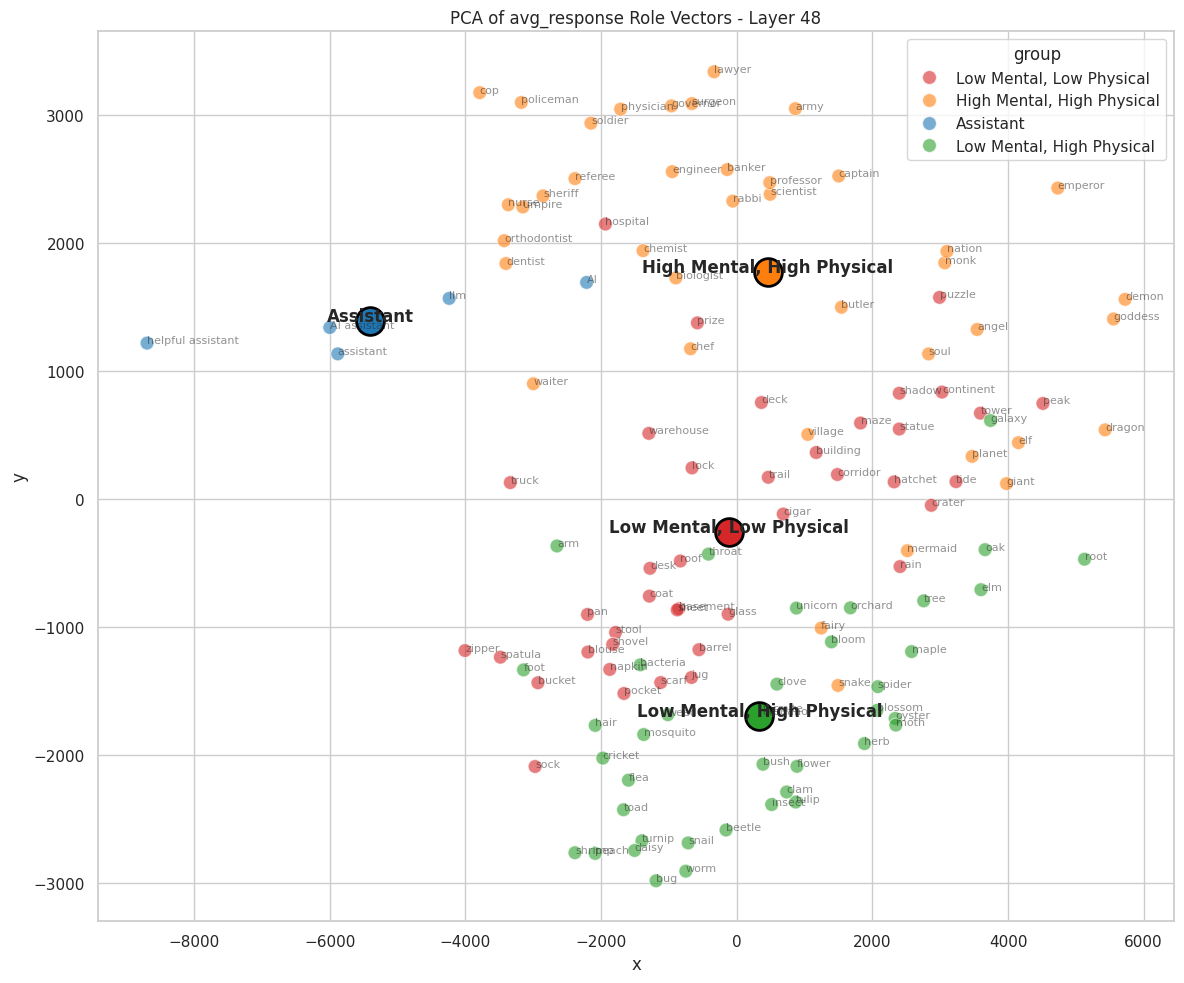

In [17]:
# Visualize avg_response with PCA
if 'role_vectors_3' in locals():
    visualize_role_vectors(role_vectors_3, "avg_response", method='pca')

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


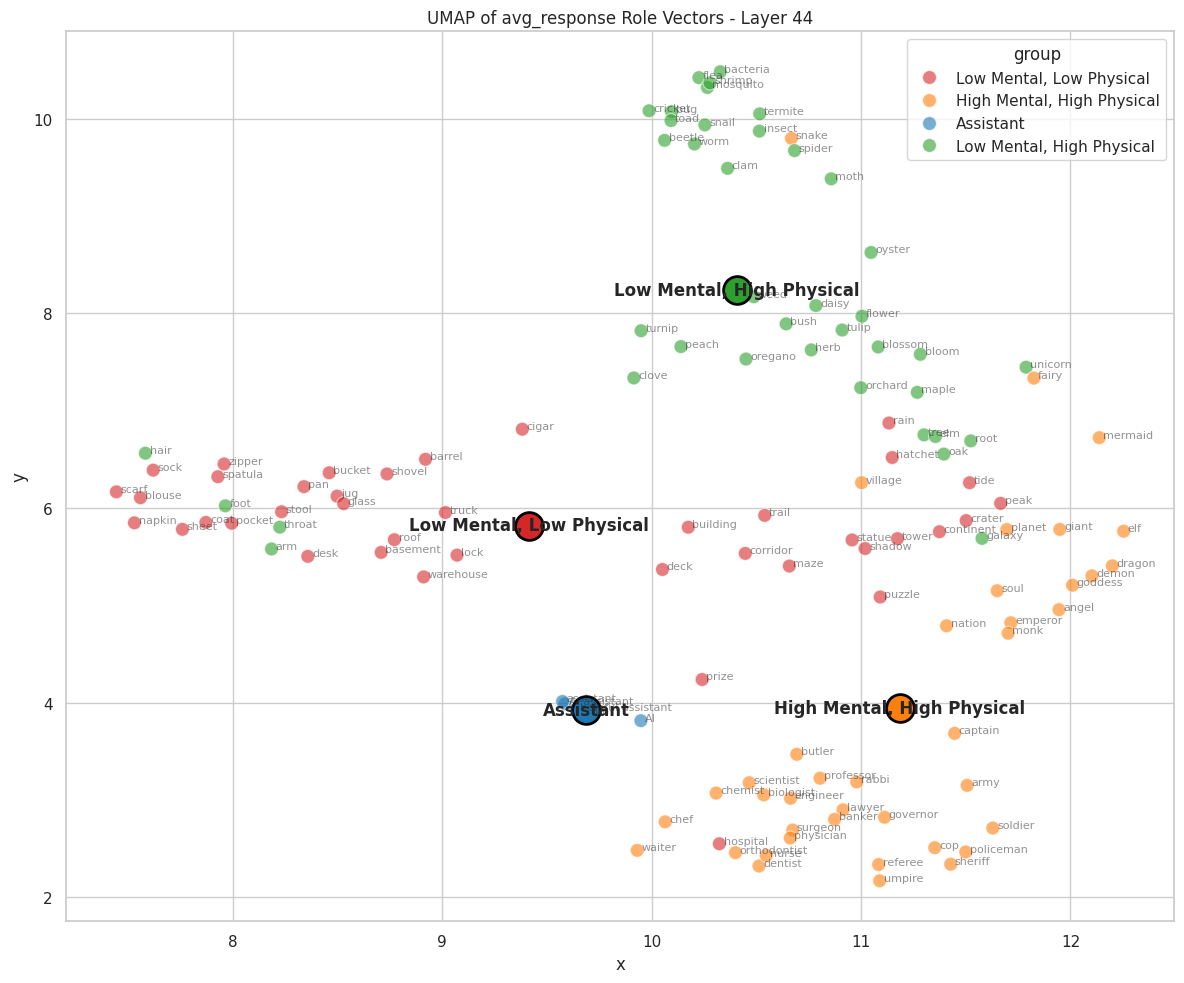

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


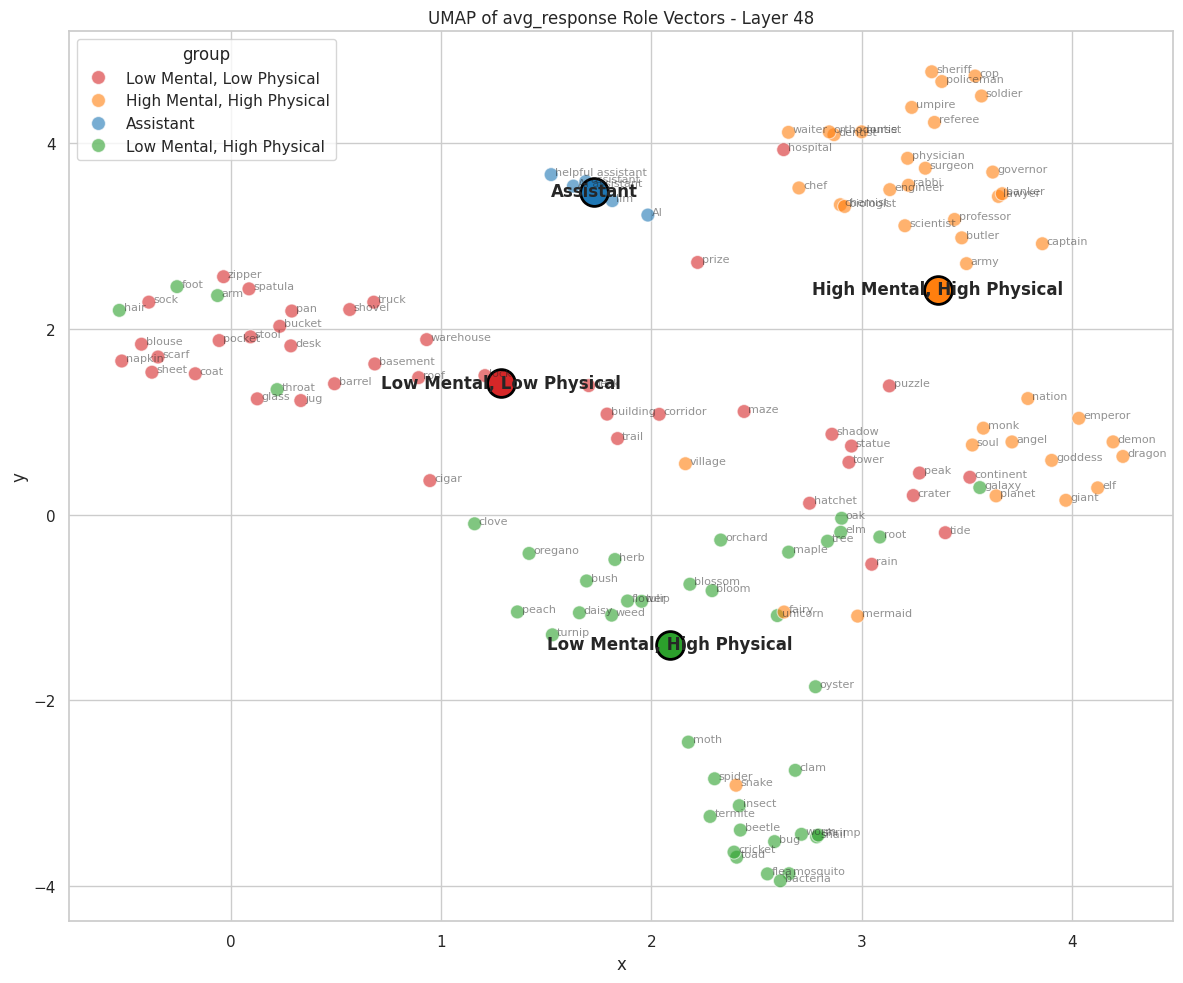

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


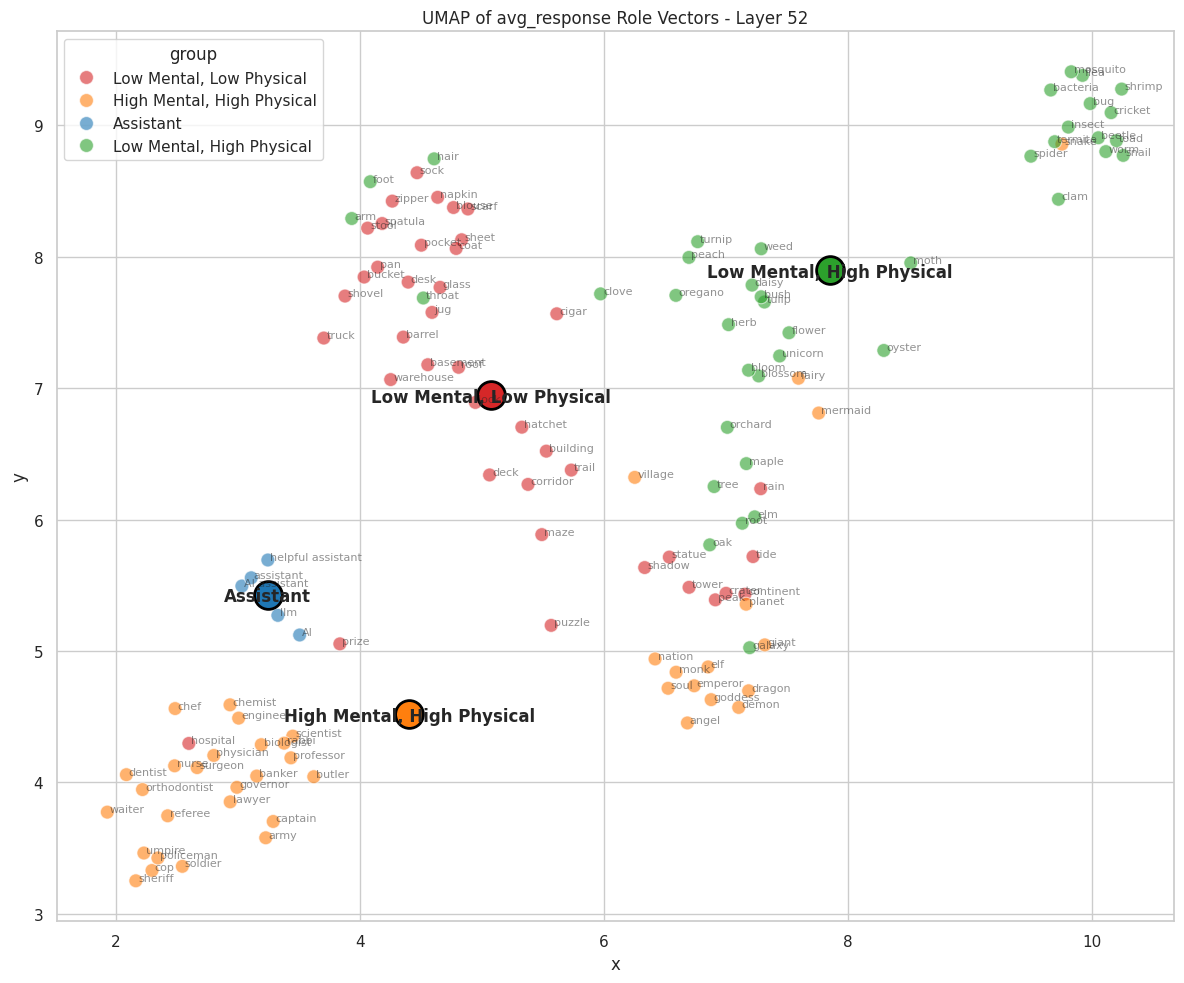

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


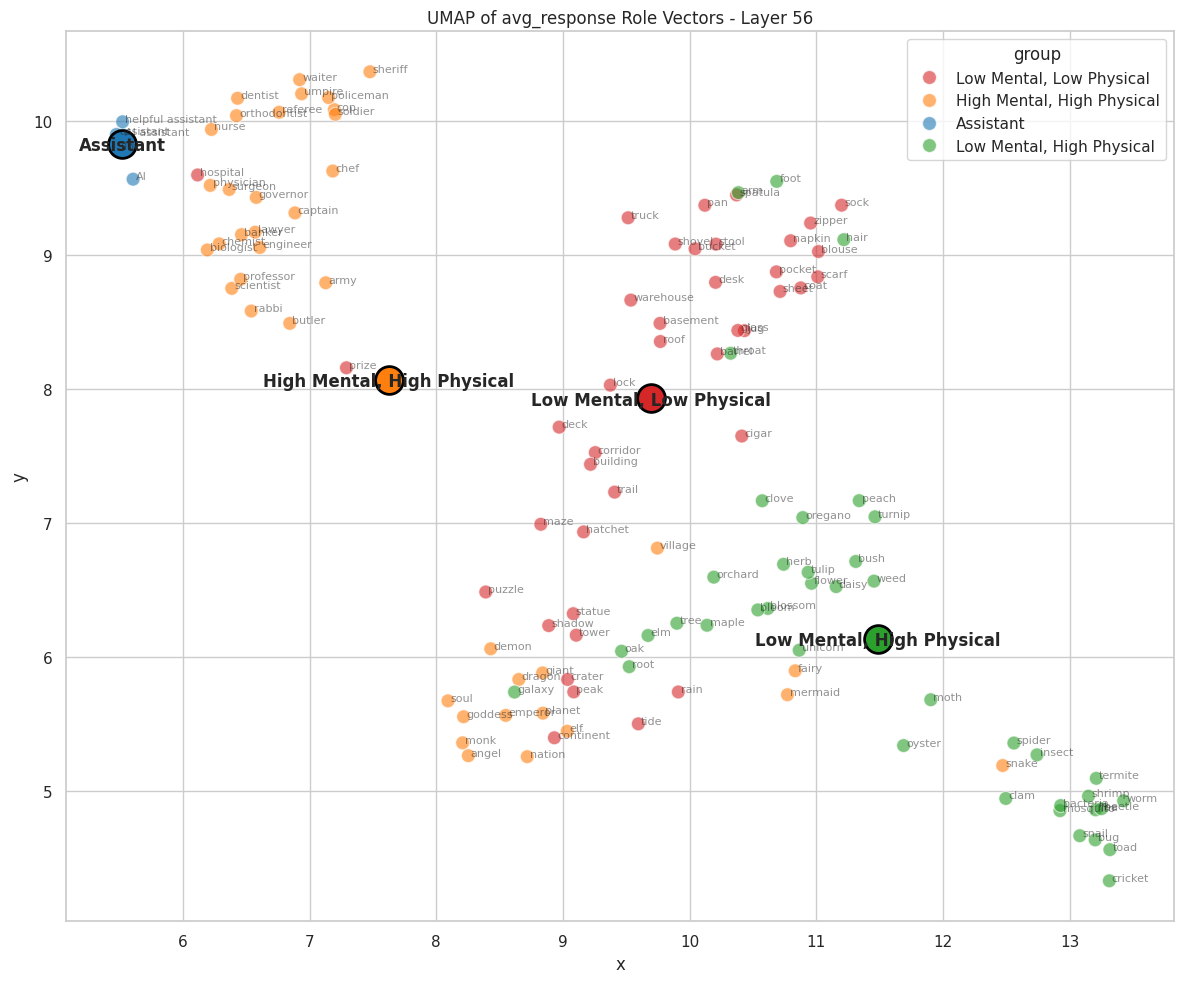

In [18]:
# Visualize avg_response with UMAP
if 'role_vectors_3' in locals():
    visualize_role_vectors(role_vectors_3, "avg_response", method='umap')

## 4. avg_response_first_10_tokens (filtered, baseline subtracted)

In [19]:
if not df_with_sys.empty:
    # 4) avg_response_first_10_tokens (Filtered)
    metric = "avg_response_first_10_tokens"
    baseline = get_assistant_baseline(df_with_sys, metric)
    role_vectors_4 = compute_and_save_metric(df_with_sys, metric, metric, filter_deviations=True, assistant_baseline=baseline)

Filtered avg_response_first_10_tokens: 24999 -> 24999 rows.


/tmp/ipykernel_173485/1232711009.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["has_deviation"] = merged["has_deviation"].fillna(False)


Computing avg_response_first_10_tokens:   0%|          | 0/125 [00:00<?, ?it/s]

Saved avg_response_first_10_tokens to ../../steering/data/gemma-3-27b-it/role_vectors_avg_response_first_10_tokens.pkl


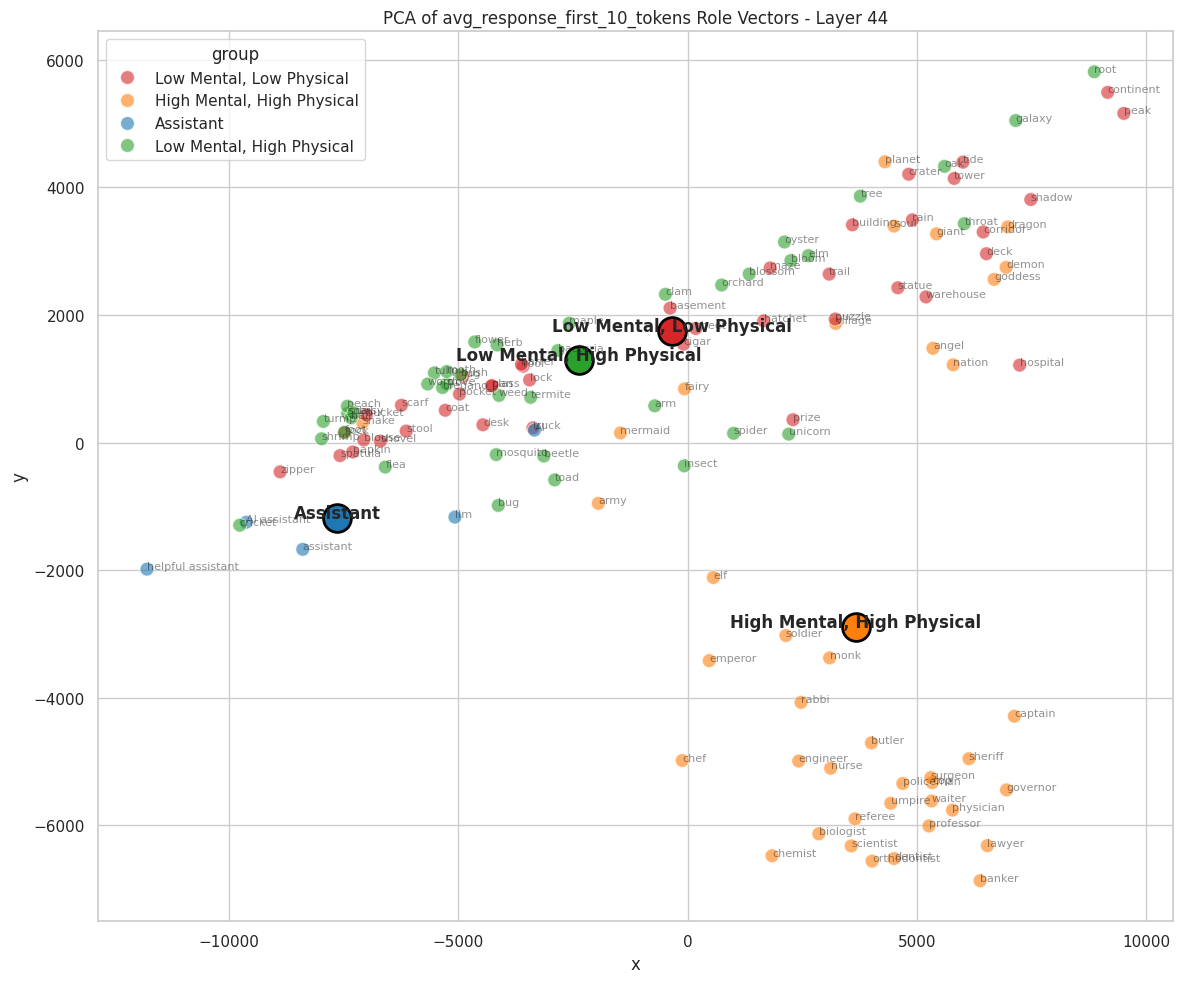

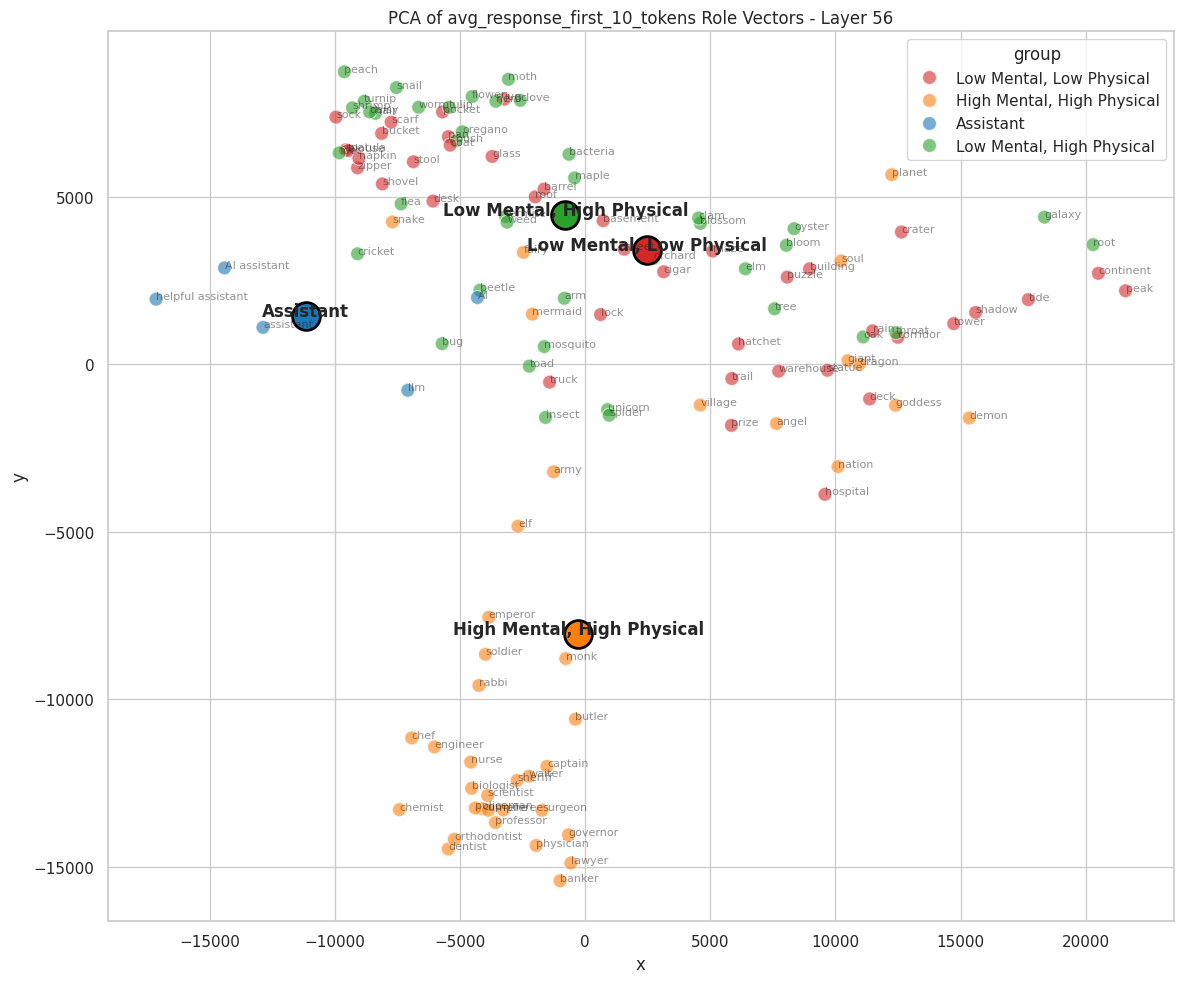

In [20]:
# Visualize avg_response_first_10_tokens with PCA
if 'role_vectors_4' in locals():
    visualize_role_vectors(role_vectors_4, "avg_response_first_10_tokens", method='pca')

In [21]:
# Visualize avg_response_first_10_tokens with UMAP
if 'role_vectors_4' in locals():
    visualize_role_vectors(role_vectors_4, "avg_response_first_10_tokens", method='umap')

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 5. avg_response_sys_diff (with_sys - without_sys)

In [22]:
# 5) avg_response (with_sys - without_sys)
df_without_sys = load_activations(ACTIVATIONS_DIR, "without_sys")

if df_without_sys.empty:
    print("ERROR: df_without_sys is empty!")
else:
    parsed_wo = df_without_sys["filename_stem"].apply(lambda x: parse_role_task(x, known_roles, known_tasks))
    df_without_sys["role"] = parsed_wo.apply(lambda x: x[0])
    df_without_sys["task"] = parsed_wo.apply(lambda x: x[1])

    print(f"Loaded {len(df_without_sys)} without_sys activations.")

    if not df_with_sys.empty:
        metric = "avg_response"
        merged_sys = pd.merge(
            df_with_sys[["role", "task", "sample_idx", "layer", metric]],
            df_without_sys[["role", "task", "sample_idx", "layer", metric]],
            on=["role", "task", "sample_idx", "layer"],
            suffixes=("_with", "_without")
        )

        print(f"Merged {len(merged_sys)} pairs for system prompt diff.")

        merged_sys["diff"] = merged_sys[f"{metric}_with"] - merged_sys[f"{metric}_without"]

        role_vectors_diff = {}
        roles = merged_sys["role"].unique()
        layers = merged_sys["layer"].unique()

        for role in tqdm(roles, desc="Computing avg_response_diff"):
            role_vectors_diff[role] = {}
            role_df = merged_sys[merged_sys["role"] == role]
            
            for layer in layers:
                layer_data = role_df[role_df["layer"] == layer]["diff"]
                if layer_data.empty:
                    continue
                    
                vectors = np.stack(layer_data.values)
                avg_vector = np.mean(vectors, axis=0)
                role_vectors_diff[role][layer] = avg_vector

        output_path = OUTPUT_DIR / "role_vectors_avg_response_sys_diff.pkl"
        with open(output_path, "wb") as f:
            pickle.dump(role_vectors_diff, f)
        print(f"Saved avg_response_sys_diff to {output_path}")
        
        role_vectors_5 = role_vectors_diff

Checking summaries dir: /home/nate/repos/animacy/results/activations/data/gemma-3-27b-it/without_sys/summaries
Loading 25000 files from without_sys...


  0%|          | 0/25000 [00:00<?, ?it/s]

Loaded 25000 without_sys activations.
Merged 24999 pairs for system prompt diff.


Computing avg_response_diff:   0%|          | 0/125 [00:00<?, ?it/s]

Saved avg_response_sys_diff to ../../steering/data/gemma-3-27b-it/role_vectors_avg_response_sys_diff.pkl


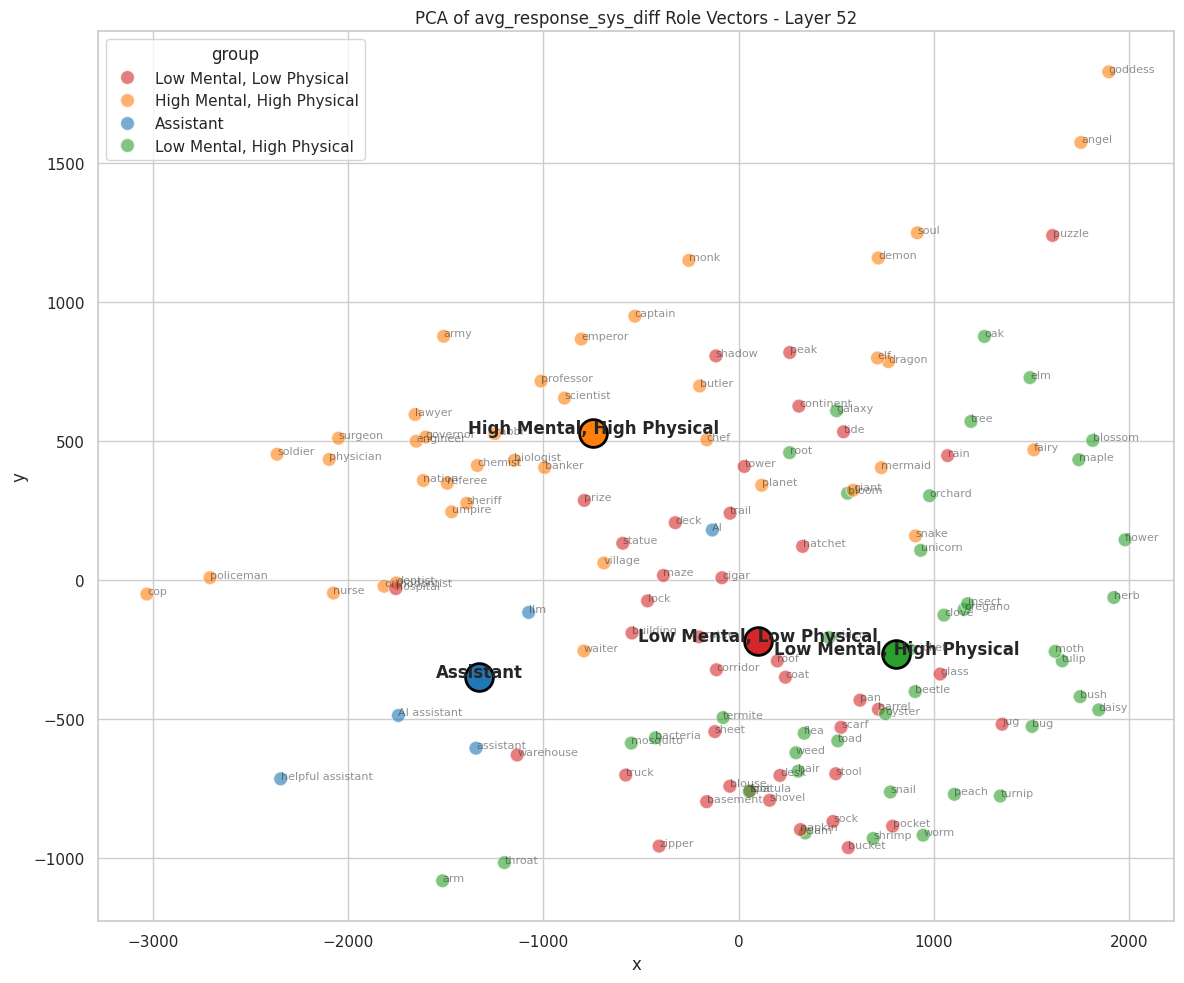

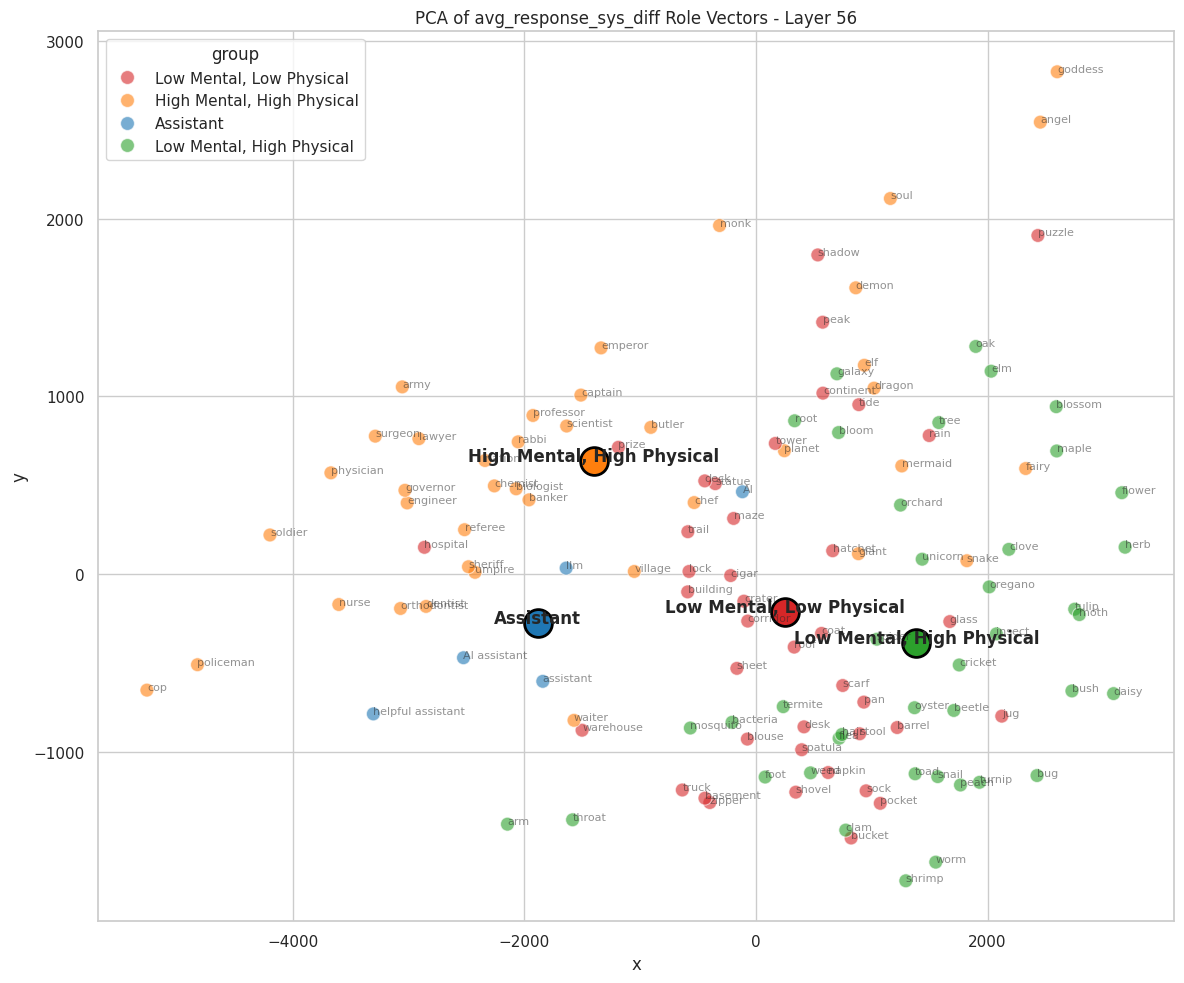

In [23]:
# Visualize avg_response_sys_diff with PCA
if 'role_vectors_5' in locals():
    visualize_role_vectors(role_vectors_5, "avg_response_sys_diff", method='pca')

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


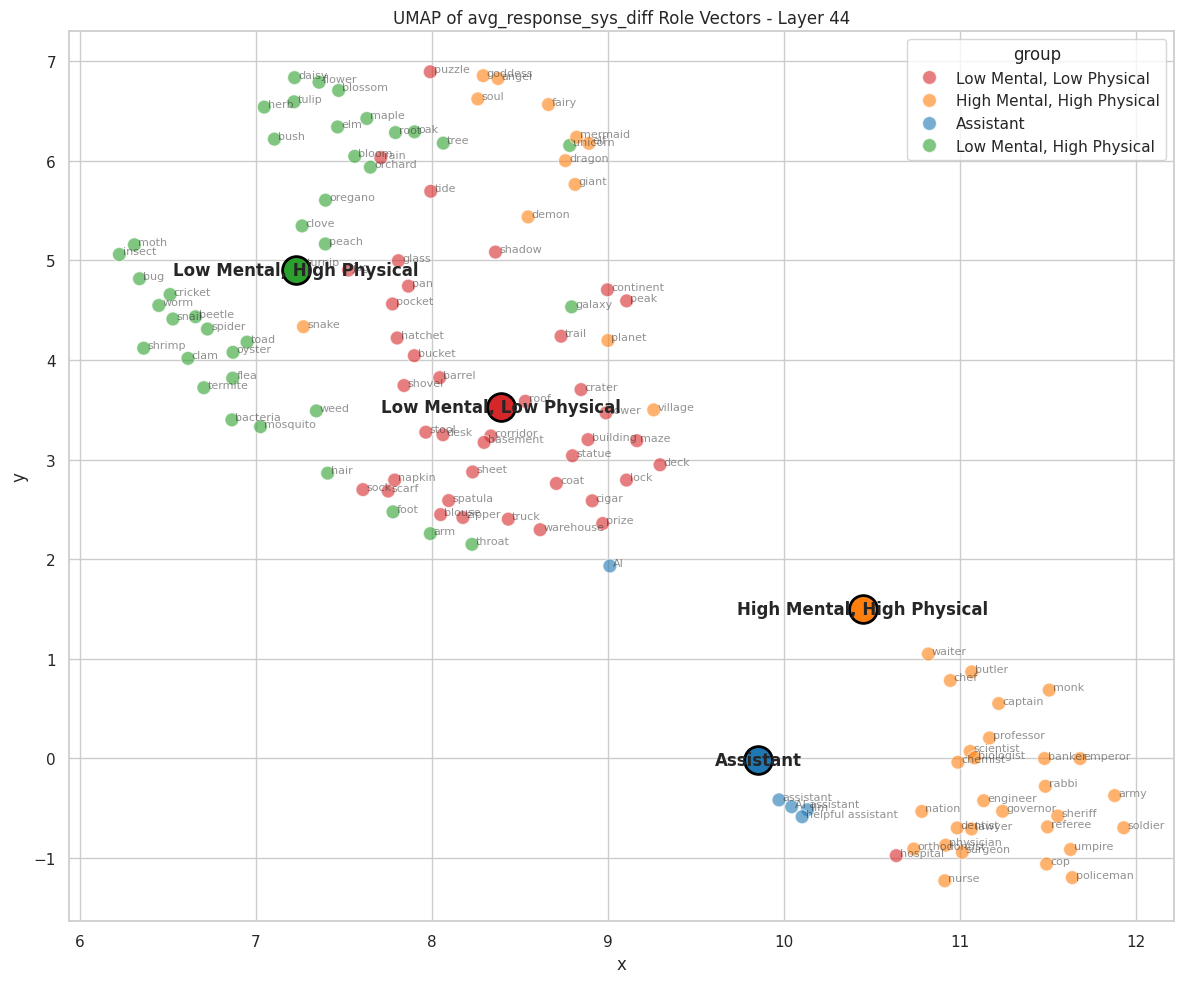

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


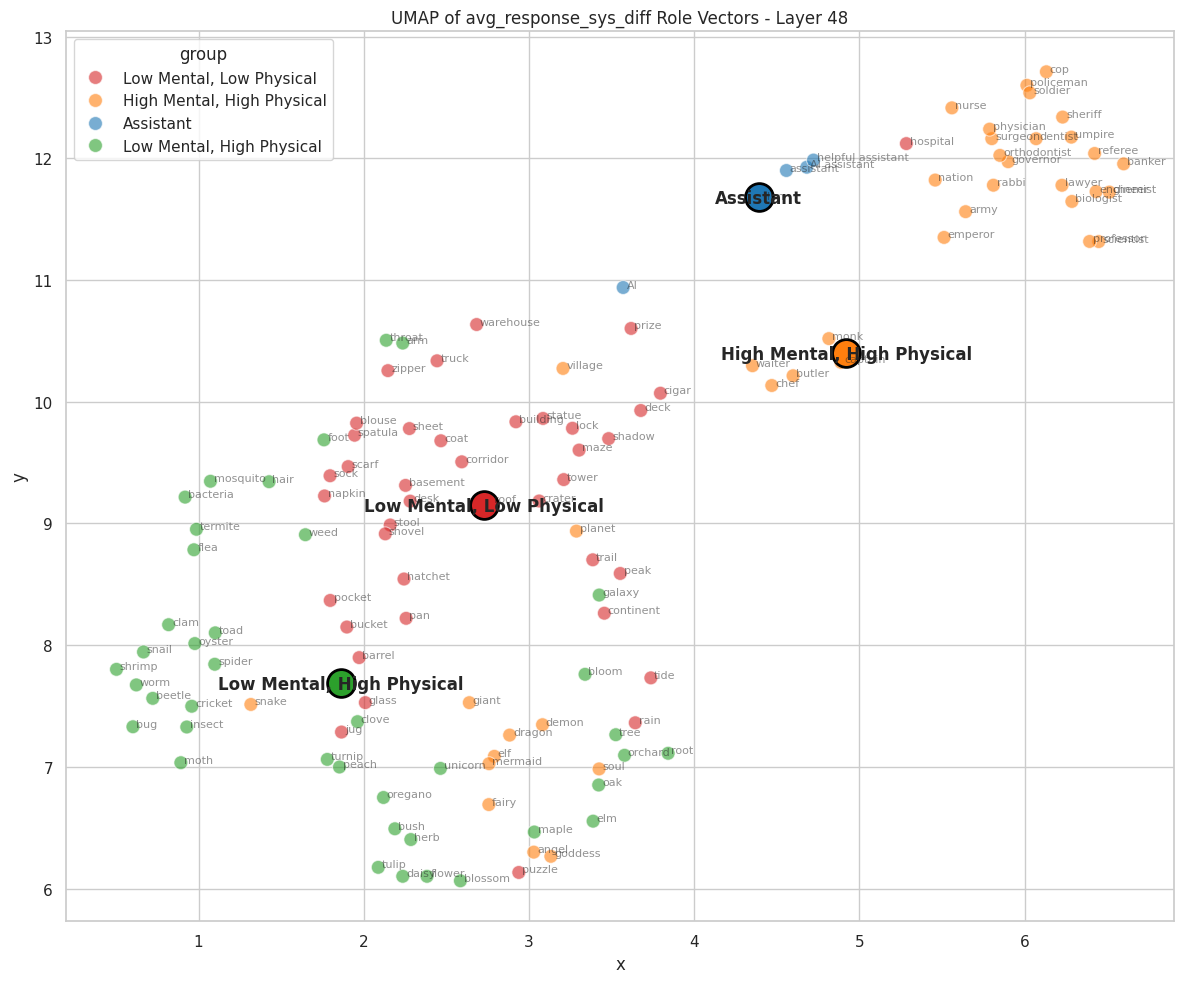

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


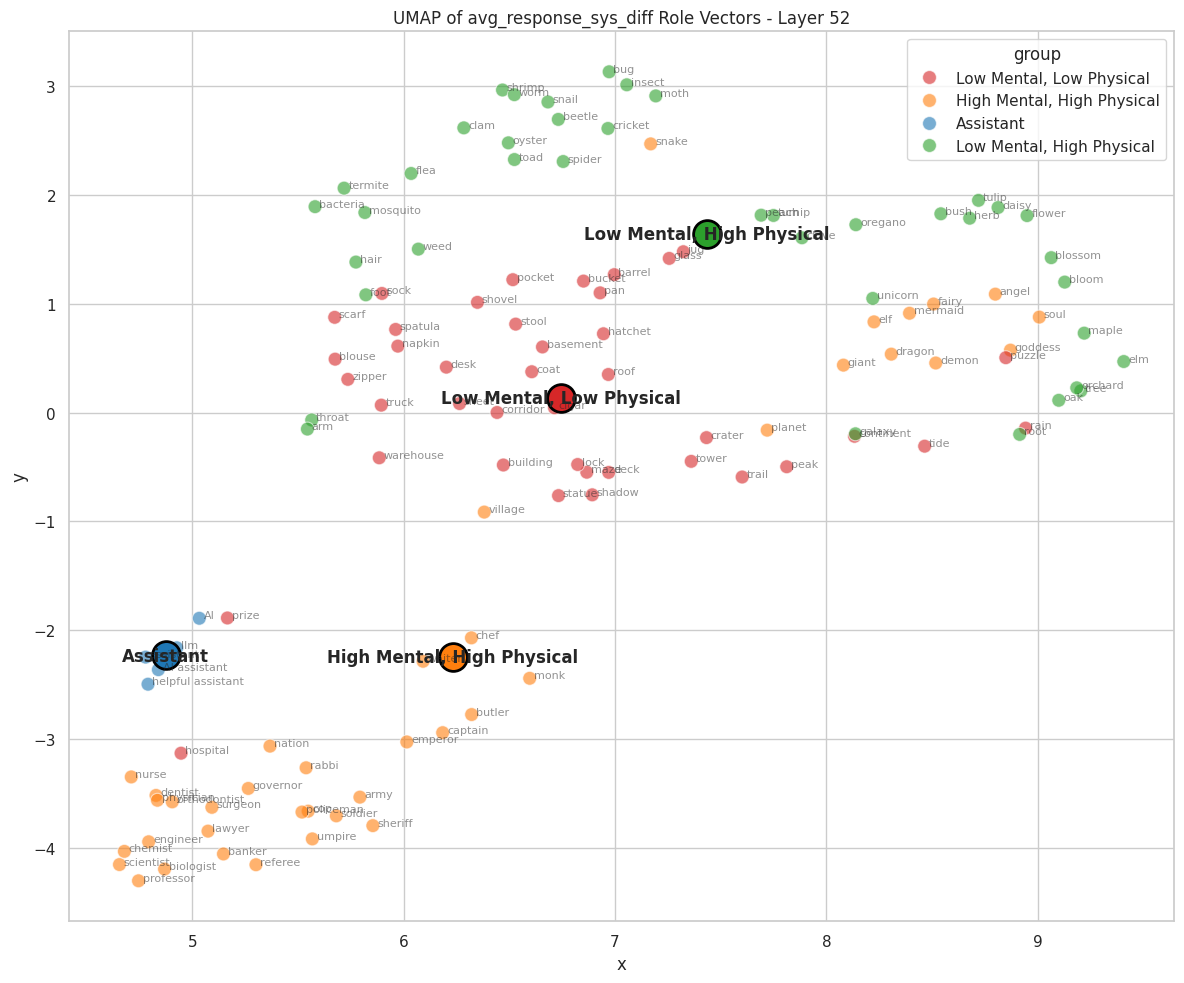

/home/nate/repos/animacy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


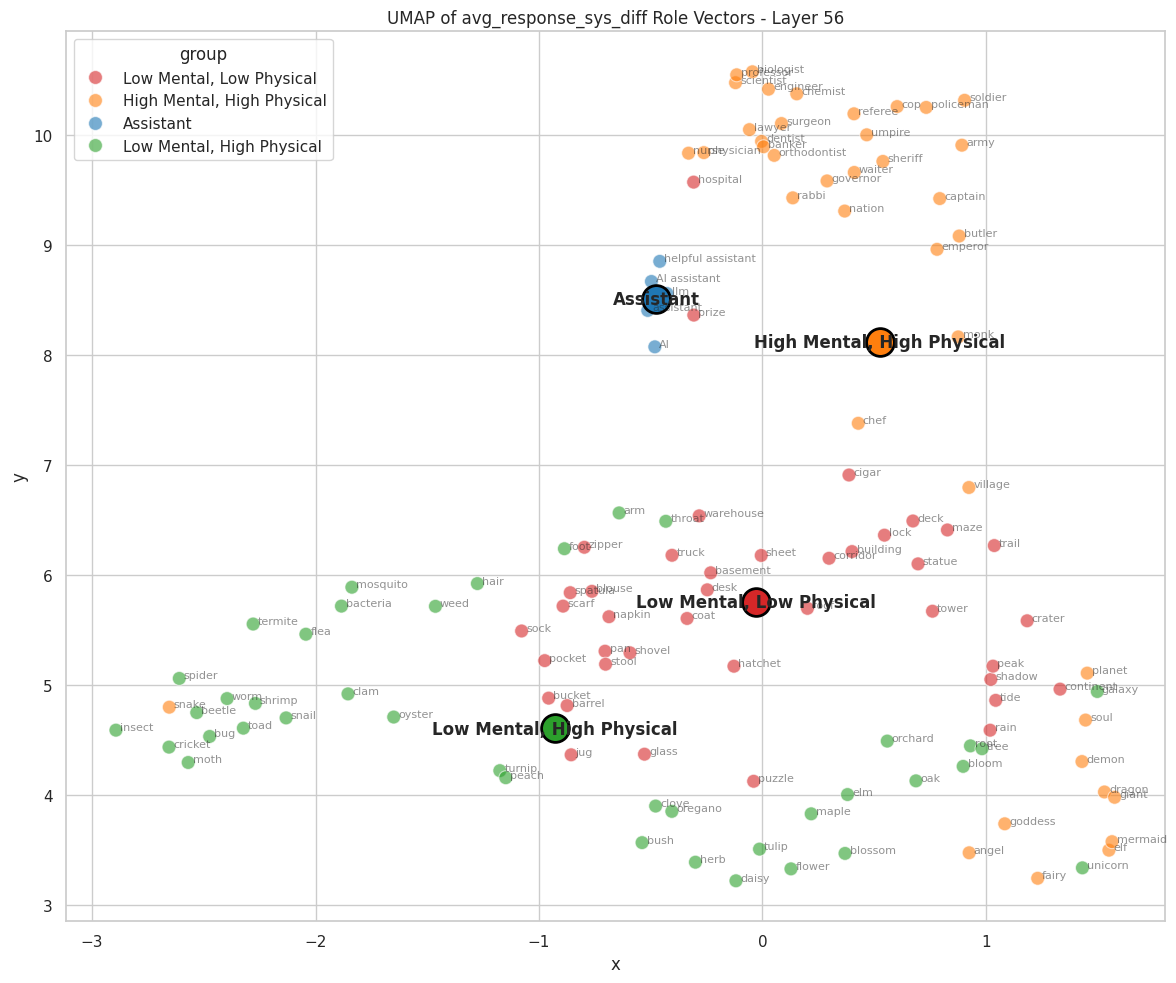

In [24]:
# Visualize avg_response_sys_diff with UMAP
if 'role_vectors_5' in locals():
    visualize_role_vectors(role_vectors_5, "avg_response_sys_diff", method='umap')